# Predicting Diatom concentration with functional clustering and regression (grid points)

## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore as xs

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import r_regression

from skfda.representation.grid import FDataGrid
from skfda.ml.clustering import KMeans

from skfda.ml.regression import HistoricalLinearRegression

from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix, LocalLinearRegressionHatMatrix, KNeighborsHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother

from sklearn.metrics import root_mean_squared_error as rmse

import os
import lzma
import dill

import random

import cmocean.cm as cm
import salishsea_tools.viz_tools as sa_vi

np.warnings.filterwarnings('ignore') # For the nan mean warning


## Datasets Preparation

In [2]:
# Creation of the training - testing datasets
def datasets_preparation(dataset, dataset2, clusters, name):
    
    indx = np.where((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))
    
    targets = dataset[name].to_numpy().reshape(*dataset[name].to_numpy().shape[:1],-1)
    
    inputs = np.stack([
        dataset2['Summation_of_solar_radiation'].to_numpy().reshape(*dataset2['Summation_of_solar_radiation'].to_numpy().shape[:1],-1),
        dataset2['Mean_wind_speed'].to_numpy().reshape(*dataset2['Mean_wind_speed'].to_numpy().shape[:1],-1),
        dataset2['Mean_air_temperature'].to_numpy().reshape(*dataset2['Mean_air_temperature'].to_numpy().shape[:1],-1),
        ])

    # Deleting 29 of February
    inputs = np.delete(inputs,indx,axis=1)
    targets = np.delete(targets,indx,axis=0)

    # Splitting in years
    inputs = np.split(inputs,len(np.unique(dataset.time_counter.dt.year)),axis=1)
    targets = np.split(targets,len(np.unique(dataset.time_counter.dt.year)),axis=0)

    # Grouping all the years (amount of days for one year * amount of grid boxes)
    inputs = np.concatenate(inputs,axis=2)
    targets = np.concatenate(targets,axis=1)

    x = np.tile(dataset.x, len(np.unique(dataset.time_counter.dt.year))*len(dataset.y))
    y = np.tile(np.repeat(dataset.y, len(dataset.x)), len(np.unique(dataset.time_counter.dt.year)))

    indx = np.where((~np.isnan(targets).any(axis=0))& (x>10) & ((x>100) | (y<880)))
    inputs = inputs[:,:,indx[0]]
    targets = targets[:,indx[0]]

    clusters = np.tile(np.ravel(clusters), len(dataset.time_counter))
    clusters = clusters[indx[0]]

    return(inputs, targets, indx, clusters)


## Clustering Finalization

In [3]:
def clustering(dataset,quant,indx,name):

    # Training
    n_clusters = 6
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(quant)

    unique, _ = np.unique(clusters, return_counts=True)

    # Creating the map
    indx2 = np.full(len(dataset.y) * len(dataset.x),np.nan)
    indx2[indx[0]] = clusters
    clusters = np.reshape(indx2,(len(dataset.y),len(dataset.x))) 
    clusters2 = xr.DataArray(clusters,dims = ['y','x'])
    
    # Plotting
    fig, ax = plt.subplots(figsize =(5,9))

    cmap = plt.get_cmap('tab20', unique.max()+1)
    cmap.set_bad('gray')
    clus = clusters2.plot(ax=ax, cmap=cmap, vmin = unique.min(), vmax = unique.max()+1, add_colorbar=False)

    cbar = fig.colorbar(clus, ticks = unique+0.5) 
    cbar.set_ticklabels(unique+1)
    cbar.set_label('Clusters [count]')
    ax.set_title('Functional Clustering for '+ name + ' (2007-2020)')

    sa_vi.set_aspect(ax)
    plt.show()

    return(clusters)
    

## Functional Clustering (Target)

In [4]:
def func_clust_target(dataset, name):

    indx = np.where((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))
    
    targets = dataset[name].to_numpy().reshape(*dataset[name].to_numpy().shape[:1],-1)

    # Deleting 29 of February
    targets = np.delete(targets,indx,axis=0)

    # Splitting in years
    targets = np.split(targets,len(np.unique(dataset.time_counter.dt.year)),axis=0)

    # Means
    targets = np.nanmean(targets,axis=0)

    x =  np.tile(dataset.x, len(dataset.y))
    y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

    indx = np.where((~np.isnan(targets).any(axis=0))& (x>10) & ((x>100) | (y<880)))
    targets = targets[:,indx[0]]

    # Converting it to an appropriate format for functional clustering
    targets = targets.transpose()
    targets2 = FDataGrid(targets)

    clusters = clustering(dataset,targets2,indx,name)

    return(clusters,0)


## Functional Clustering (Drivers)

In [5]:
def func_clust_drivers(dataset,dataset2,name):

    indx = np.where((dataset2.time_counter.dt.month==2) & (dataset2.time_counter.dt.day==29))

    targets = dataset[name].to_numpy().reshape(*dataset[name].to_numpy().shape[:1],-1)

    inputs = np.stack([
        dataset2['Summation_of_solar_radiation'].to_numpy().reshape(*dataset2['Summation_of_solar_radiation'].to_numpy().shape[:1],-1),
        dataset2['Mean_pressure'].to_numpy().reshape(*dataset2['Mean_pressure'].to_numpy().shape[:1],-1),
        dataset2['Mean_precipitation'].to_numpy().reshape(*dataset2['Mean_precipitation'].to_numpy().shape[:1],-1),
        dataset2['Mean_specific_humidity'].to_numpy().reshape(*dataset2['Mean_specific_humidity'].to_numpy().shape[:1],-1),
        dataset2['Mean_air_temperature'].to_numpy().reshape(*dataset2['Mean_air_temperature'].to_numpy().shape[:1],-1),
        ])

    # Deleting 29 of February
    inputs = np.delete(inputs,indx,axis=1)
    targets = np.delete(targets,indx,axis=0)

    # Splitting in years
    inputs = np.split(inputs,len(np.unique(dataset2.time_counter.dt.year)),axis=1)
    targets = np.split(targets,len(np.unique(dataset2.time_counter.dt.year)),axis=0)

    # Means
    inputs = np.nanmean(inputs,axis=0)
    targets = np.nanmean(targets,axis=0)

    x =  np.tile(dataset2.x, len(dataset2.y))
    y =  np.tile(np.repeat(dataset2.y, len(dataset2.x)),1)

    indx = np.where((~np.isnan(targets).any(axis=0))& (x>10) & ((x>100) | (y<880)))
    inputs = inputs[:,:,indx[0]]

    # Scaling the inputs
    temp = np.reshape(inputs,(len(inputs),inputs.shape[1]*inputs.shape[2]))
    temp = temp.transpose()
    scaler_inputs = make_column_transformer((StandardScaler(), [0,1,2,3,4,5]))
    temp = scaler_inputs.fit_transform(temp)
    temp = temp.transpose()
    inputs = np.reshape(temp,(len(inputs),inputs.shape[1],inputs.shape[2])) 

    # Converting it to an appropriate format for functional clustering
    inputs = np.transpose(inputs,axes=(2,1,0))
    inputs2 = FDataGrid(inputs, np.arange(0,len(inputs[0])))

    clusters = clustering(dataset2,inputs2,indx,'inputs')

    return(clusters, 1)


## Datasets Preparation 2

In [6]:
# Creation of the data arrays
def datasets_preparation2(variable, name, units, dataset, indx):

    # Creating the maps size (with nans)
    variable_all = np.full((len(variable), len(dataset.y) * len(dataset.x)),np.nan)
    variable_all[:,indx[0]] = variable
    variable_all = np.reshape(variable_all,(len(variable),len(dataset.y),len(dataset.x)))

    dates = pd.DatetimeIndex(dataset['time_counter'].values)
    indx2 = ~((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))
    dates = dates[indx2]

    # Preparation of the dataarray 
    array = xr.DataArray(variable_all,
        coords = {'time_counter': dates,'y': dataset.y, 'x': dataset.x},
        dims = ['time_counter','y','x'],
        attrs=dict(description= name,
        units=units))
        
    return (array)


## File Creation

In [7]:
def file_creation(path, variable, name):

    temp = variable.to_dataset(name=name)
    temp.to_netcdf(path = path + 'targets_predictions.nc', mode='a', encoding={name:{"zlib": True, "complevel": 9}})
    

## Regressor

In [8]:
def regressor (inputs, targets, name, cluster):

    # Printing of the correlation coefficients
    temp_inputs = np.reshape(inputs,(len(inputs),inputs.shape[1]*inputs.shape[2]))
    temp_inputs = temp_inputs.transpose()
    temp_targets = np.ravel(targets)

    # r = np.round(r_regression(temp_inputs,temp_targets),2)
    # dict = {'Summation_of_solar_radiation':r[0], 'Mean_wind_speed':r[1], 'Mean_air_temperature':r[2]}
    
    # print('The correlation coefficients between each input and ' + name +  ' for cluster ' + str(cluster+1) + ' are: ' +str(dict))

    # Scaling the inputs
    scaler_inputs = make_column_transformer((StandardScaler(), [0,1,2]))
    temp_inputs = scaler_inputs.fit_transform(temp_inputs)
    temp_inputs = temp_inputs.transpose()
    inputs = np.reshape(temp_inputs,(len(inputs),inputs.shape[1],inputs.shape[2]))   
    inputs = np.transpose(inputs,axes=(2,1,0))
    
    # Scaling the targets
    scaler_targets = StandardScaler()
    temp_targets = np.expand_dims(temp_targets,-1)
    temp_targets = scaler_targets.fit_transform(temp_targets)
    targets = temp_targets.reshape(targets.shape)

    # Final transformations
    targets = targets.transpose()
    inputs = FDataGrid(data_matrix=inputs, grid_points=np.arange(0,len(targets[0])))
    targets = FDataGrid(data_matrix=targets, grid_points=np.arange(0,len(targets[0])))

    ## Smoothing
    # targets = targets.to_basis(FourierBasis(n_basis=10)
    kernel_estimator = LocalLinearRegressionHatMatrix(bandwidth=1)
    smoother = KernelSmoother(kernel_estimator=kernel_estimator)
    inputs = smoother.fit_transform(inputs)

    model = HistoricalLinearRegression(n_intervals=4,lag=25)
    regr = model.fit(inputs,targets)

    return(regr,scaler_inputs,scaler_targets,smoother)


## Scaling

In [9]:
def scaling(regr,inputs,scaler_inputs,targets,scaler_targets,smoother):

    # Scaling the inputs
    temp = np.reshape(inputs,(len(inputs),inputs.shape[1]*inputs.shape[2]))
    temp = temp.transpose()
    temp = scaler_inputs.transform(temp)
    temp = temp.transpose()        
    inputs = np.reshape(temp,(len(inputs),inputs.shape[1],inputs.shape[2]))
        
    inputs = np.transpose(inputs,axes=(2,1,0))
    inputs = FDataGrid(data_matrix=inputs, grid_points=np.arange(0,len(targets)))

    inputs = smoother.transform(inputs)

    predictions = regr.predict(inputs)

    # Post-processing of predictions
    predictions = np.array(predictions.to_grid(np.arange(0,len(targets))).data_matrix)
    predictions = np.squeeze(predictions,2)

    # Scaling the predictions
    temp = np.ravel(predictions)
    temp = np.expand_dims(temp,axis=-1)
    temp = scaler_targets.inverse_transform(temp)
    predictions = temp.reshape(predictions.shape)
    predictions = predictions.transpose()

    return(predictions)


## Scatter Plot

In [10]:
def scatter_plot(targets, predictions, name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, predictions, deg=1)

    fig, ax = plt.subplots(2, figsize=(5,10), layout='constrained')

    ax[0].scatter(targets,predictions, alpha = 0.2, s = 10)

    lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
        np.max([ax[0].get_xlim(), ax[0].get_ylim()])]

    # plot fitted y = m*x + b
    ax[0].axline(xy1=(0, b), slope=m, color='r')

    ax[0].set_xlabel('targets')
    ax[0].set_ylabel('predictions')
    ax[0].set_xlim(lims)
    ax[0].set_ylim(lims)
    ax[0].set_aspect('equal')

    ax[0].plot(lims, lims,linestyle = '--',color = 'k')

    h = ax[1].hist2d(targets,predictions, bins=100, cmap='jet', 
        range=[lims,lims], cmin=0.1, norm='log')
    
    ax[1].plot(lims, lims,linestyle = '--',color = 'k')

    # plot fitted y = m*x + b
    ax[1].axline(xy1=(0, b), slope=m, color='r')

    ax[1].set_xlabel('targets')
    ax[1].set_ylabel('predictions')
    ax[1].set_aspect('equal')

    fig.colorbar(h[3],ax=ax[1], location='bottom')

    fig.suptitle(name)

    plt.show()

    return(m)


## Seasonality

In [11]:
def seasonality (dates,targets):

    # Preparation of the dataarray 
    targets2 = xr.DataArray(targets,
        coords = {'time_counter':dates},
        dims = 'time_counter')
    
    test = targets2.groupby('time_counter.dayofyear').mean('time_counter')
    test = test.drop_isel(dayofyear=14) # Removing 29 Feb
    season = np.tile(test,len(np.unique(dates.year)))

    return(season)


## Plotting (Criteria)

In [12]:
def plotting_criteria(dates, variable, year_variable, title):
    
    indx = pd.DatetimeIndex(dates)
    fig, ax = plt.subplots()

    scatter= ax.scatter(dates,variable, marker='.', c=indx.month)
    plt.xticks(rotation=70)
    ax.legend(handles=scatter.legend_elements()[0], labels=['February','March','April'])
    ax.plot(dates[(indx.month == 3) & (indx.day == 15)], year_variable,color='red',marker='*')
    fig.suptitle(title + ' (15 Feb - 30 Apr)')
    
    fig.show()


## Plotting (Mean Values)

In [13]:
def plotting_mean_values(dates, mean_targets, mean_predictions, units, category, region):

    years = np.unique(dates.year)
    ticks = [0]
    
    fig, _ = plt.subplots(figsize=(19,5))
    
    mean_targets = np.ma.array(mean_targets)
    mean_predictions = np.ma.array(mean_predictions)

    for year in years[:-1]:
        ticks.append((np.where(dates.year==year)[0][-1]+1))
        mean_targets[(np.where(dates.year==year)[0][-1]+1)] = np.ma.masked
        mean_predictions[(np.where(dates.year==year)[0][-1]+1)] = np.ma.masked

    plt.plot(mean_targets, label = 'targets')
    plt.plot(mean_predictions, label = 'predictions')
    plt.xlabel('Years')
    plt.xticks(ticks,years)
    plt.suptitle('Mean '+category + ' ' +units + ' (15 Feb - 30 Apr) ' + region)
    plt.legend()
    plt.show()
    

## Plotting (Maps)

In [14]:
def plotting_maps(targets, predictions, name, units):

    fig, ax = plt.subplots(2,2, figsize = (10,15), layout='tight')

    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    targets.plot(ax=ax[0,0], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': name + ' ' + units})
    predictions.plot(ax=ax[0,1], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': name + ' ' + units})
    (targets-predictions).plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': name + ' ' + units})

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.95, 
        top=0.95, 
        wspace=0.35, 
        hspace=0.35)

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])

    ax[0,0].title.set_text('Targets')
    ax[0,1].title.set_text('Predictions')
    ax[1,0].title.set_text('Targets-Predictions')
    ax[1,1].axis('off')

    fig.suptitle(name + ' '+ str(targets.time_counter.dt.date.values))

    plt.show()
    

## Post Processing

In [15]:
def post_processing(dates,dataset,clusters,indx,targets,predictions,units,category):

    r_train = np.zeros(len(np.unique(clusters)))
    rms_train = np.zeros(len(np.unique(clusters)))
    slope_train = np.zeros(len(np.unique(clusters)))

    targets_mean = np.zeros((len(np.unique(clusters)),len(dates)))
    predictions_mean = np.zeros((len(np.unique(clusters)),len(dates)))

    for i in range (0,len(np.unique(clusters))):
        indx2 = np.where(clusters==i) # indexes of the j cluster
        targets2 = targets[:,indx2[0]] # inputs of the j cluster
        predictions2 = predictions[:,indx2[0]] # predictions of the j cluster

        r_train[i] = np.round(np.corrcoef(np.ravel(targets2), np.ravel(predictions2))[0][1],3)
        rms_train[i] = rmse(np.ravel(targets2), np.ravel(predictions2))
        m,_ = np.polyfit(np.ravel(targets2), np.ravel(predictions2), deg=1)
        slope_train[i] = np.round(m,3)

        temp = pd.DataFrame(np.vstack((r_train[i],rms_train[i],slope_train[i])).transpose(),index=['Cluster '+str(i+1)],columns=['r_train','rms_train','slope_train'])
        display(temp)

        # for the daily mean plot
        targets_mean_temp = np.split(targets2,len(np.unique(dates.year)),axis=1)
        targets_mean_temp = np.ravel(targets_mean_temp)
        targets_mean_temp = np.reshape(targets_mean_temp,(len(dates),int(len(indx2[0])/len(np.unique(dates.year)))))
        targets_mean[i] = np.mean(targets_mean_temp,axis=1)

        predictions_mean_temp = np.split(predictions2,len(np.unique(dates.year)),axis=1)
        predictions_mean_temp = np.ravel(predictions_mean_temp)
        predictions_mean_temp = np.reshape(predictions_mean_temp,(len(dates),int(len(indx2[0])/len(np.unique(dates.year)))))
        predictions_mean[i] = np.mean(predictions_mean_temp,axis=1)

        plotting_mean_values(dates, targets_mean[i], predictions_mean[i], units, category, 'Salish Sea Cluster '+str(i+1))

    return(r_train,rms_train,slope_train,targets_mean,predictions_mean)


## Evaluation

In [16]:
def evaluation (regr_all, clusters0, ds, ds2, name, units, scaler_inputs_all, scaler_targets_all, smoother_all):

    years = np.unique(ds.time_counter.dt.year)

    # For every year
    r_years = np.array([])
    rms_years = np.array([])
    slope_years = np.array([])

    # The data arrays 
    targets_all = []
    predictions_all = []

    for year in (years):

        dataset = ds.sel(time_counter=str(year))
        dataset2 = ds2.sel(time_counter=str(year))

        inputs, targets, indx, clusters  = datasets_preparation(dataset, dataset2, clusters0, name)

        # Predictions for each regressor
        predictions = np.full(targets.shape,np.nan) # size of targets without nans
        for i in range (0,len(np.unique(clusters))):
            indx2 = np.where(clusters==i) # indexes of the i cluster
            inputs2 = inputs[:,:,indx2[0]] # inputs of the i cluster
            predictions[:,indx2[0]] = scaling(regr_all[i],inputs2,scaler_inputs_all[i],targets,scaler_targets_all[i],smoother_all[i]) # putting them in the right place

        # Calculating the annual time-series
        m_year = scatter_plot(np.ravel(targets), np.ravel(predictions), name + ' for '+ str(year)) 
        r_year = np.corrcoef(np.ravel(targets), np.ravel(predictions))[0][1]
        rms_year = rmse(np.ravel(targets), np.ravel(predictions))
        
        r_years = np.append(r_years,r_year)
        rms_years = np.append(rms_years,rms_year)
        slope_years = np.append(slope_years,m_year)

        # Daily arrays
        # targets = np.reshape(targets,(len(dataset.time_counter), int(len(indx[0]) / len(dataset.time_counter))))
        # predictions = np.reshape(predictions,(len(dataset.time_counter), int(len(indx[0]) / len(dataset.time_counter))))
        targets_all.append (datasets_preparation2(targets, name + ' _targets', units, dataset, indx))
        predictions_all.append(datasets_preparation2(predictions, name + ' _predictions', units, dataset, indx))   

    # Daily arrays
    targets_all = xr.concat(targets_all, dim='time_counter')
    predictions_all = xr.concat(predictions_all, dim='time_counter')
    
    return(r_years, rms_years, slope_years, targets_all, predictions_all)


## Training

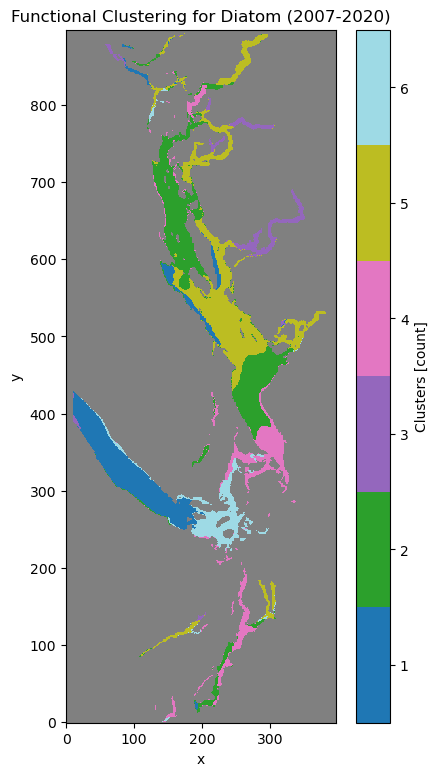

In [17]:
name = 'Diatom'
units = '[mmol m-2]'
category = 'Concentrations'

ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')

# ds = ds.isel(y=(np.arange(ds.y[0], ds.y[-1], 5)), 
#     x=(np.arange(ds.x[0], ds.x[-1], 5)))

# ds2 = ds2.isel(y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
#     x=(np.arange(ds2.x[0], ds2.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007', '2020'))
dataset2 = ds2.sel(time_counter = slice('2007', '2020'))

dates = pd.DatetimeIndex(dataset['time_counter'].values)
indx2 = ~((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))
dates = dates[indx2]

# Selecting the clustering input (drivers or target)
clusters0, id = func_clust_target(dataset, name)
# clusters0, id = func_clust_drivers(dataset,dataset2,name)

inputs, targets, indx, clusters = datasets_preparation(dataset, dataset2, clusters0, name)

regr_all = []
scaler_inputs_all = []
scaler_targets_all = []
smoother_all = []

predictions = np.full(targets.shape,np.nan) # size of targets without nans

for i in range (0,len(np.unique(clusters))):

    indx2 = np.where(clusters==i) # indexes of the i cluster
    inputs2 = inputs[:,:,indx2[0]] # inputs of the i cluster
    targets2 = targets[:,indx2[0]] # targets of the i cluster
    regr,scaler_inputs,scaler_targets,smoother = regressor(inputs2, targets2, name, i)

    scaler_inputs_all.append(scaler_inputs)
    scaler_targets_all.append(scaler_targets)
    smoother_all.append(smoother)

    regr_all.append(regr)

    predictions[:,indx2[0]] = scaling(regr_all[i],inputs2,scaler_inputs_all[i],targets,scaler_targets_all[i],smoother_all[i]) # putting them in the right place


r_train  rms_train  slope_train
Cluster 1    0.789      0.073        0.623

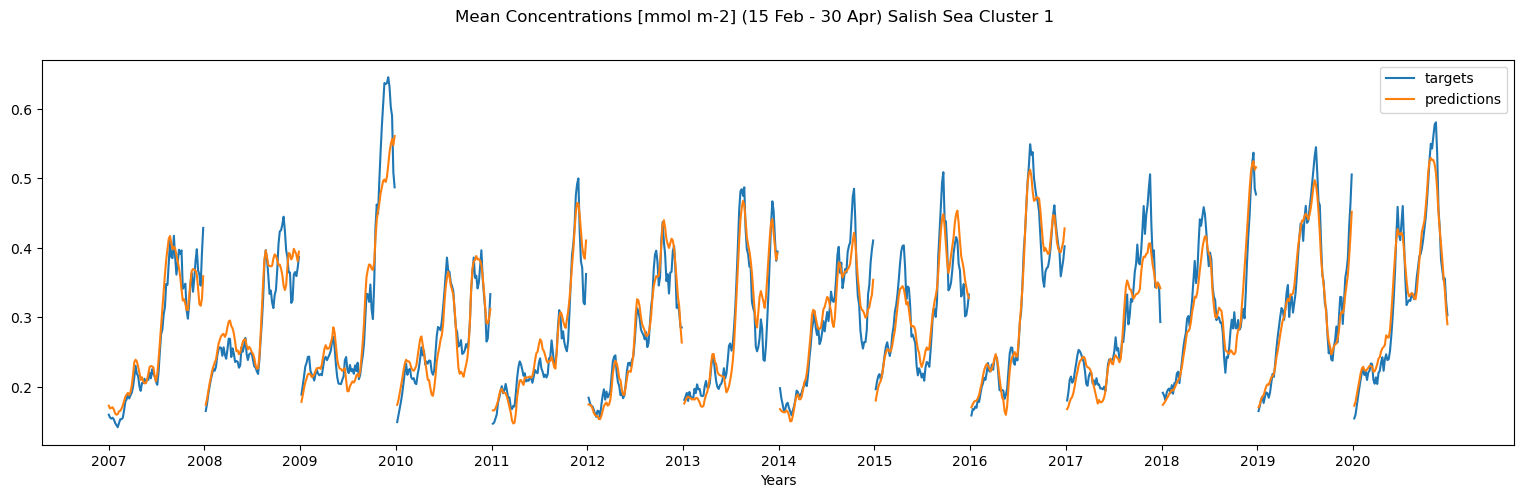

r_train  rms_train  slope_train
Cluster 2     0.81   0.103764        0.657

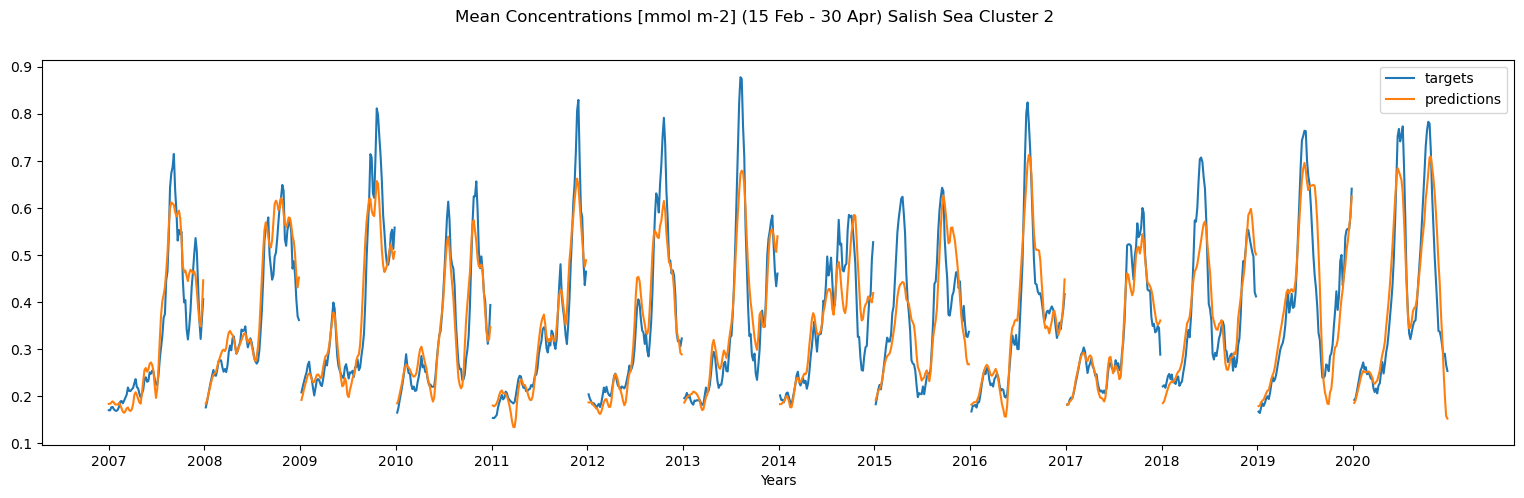

r_train  rms_train  slope_train
Cluster 3    0.728    0.09011        0.531

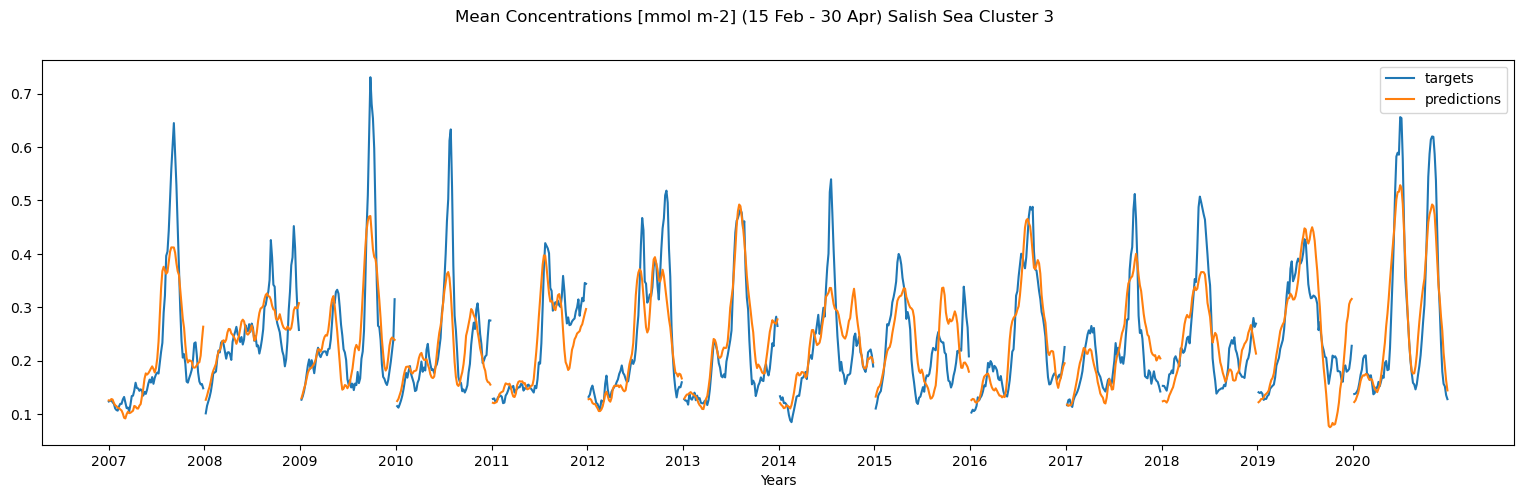

r_train  rms_train  slope_train
Cluster 4    0.833   0.105797        0.693

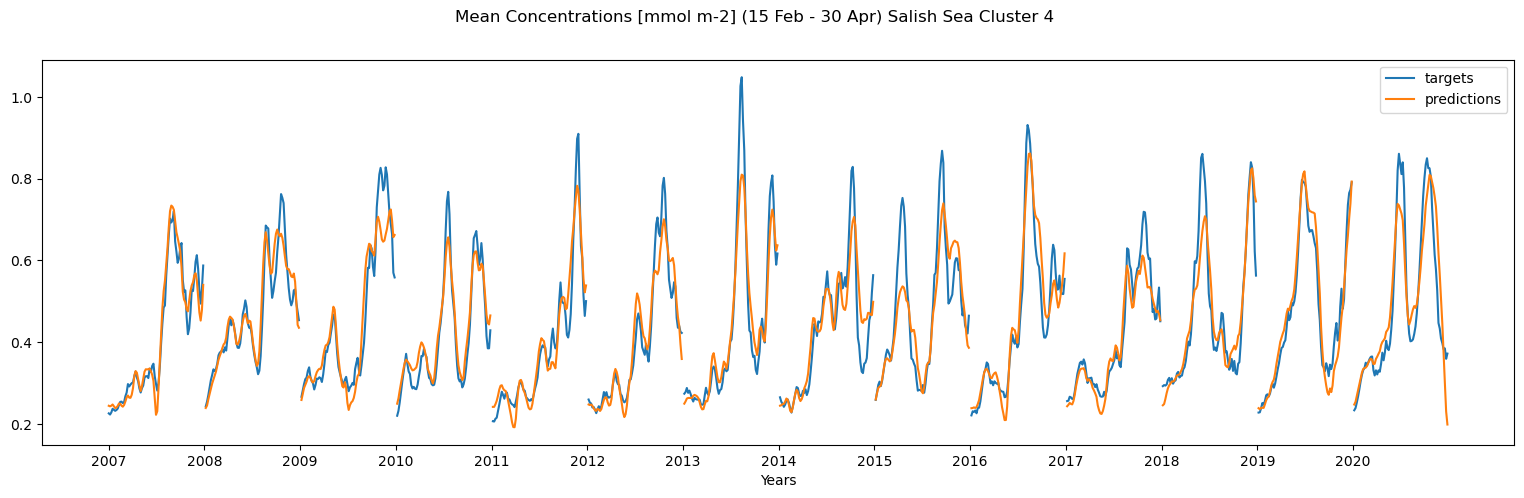

r_train  rms_train  slope_train
Cluster 5    0.779   0.098289        0.607

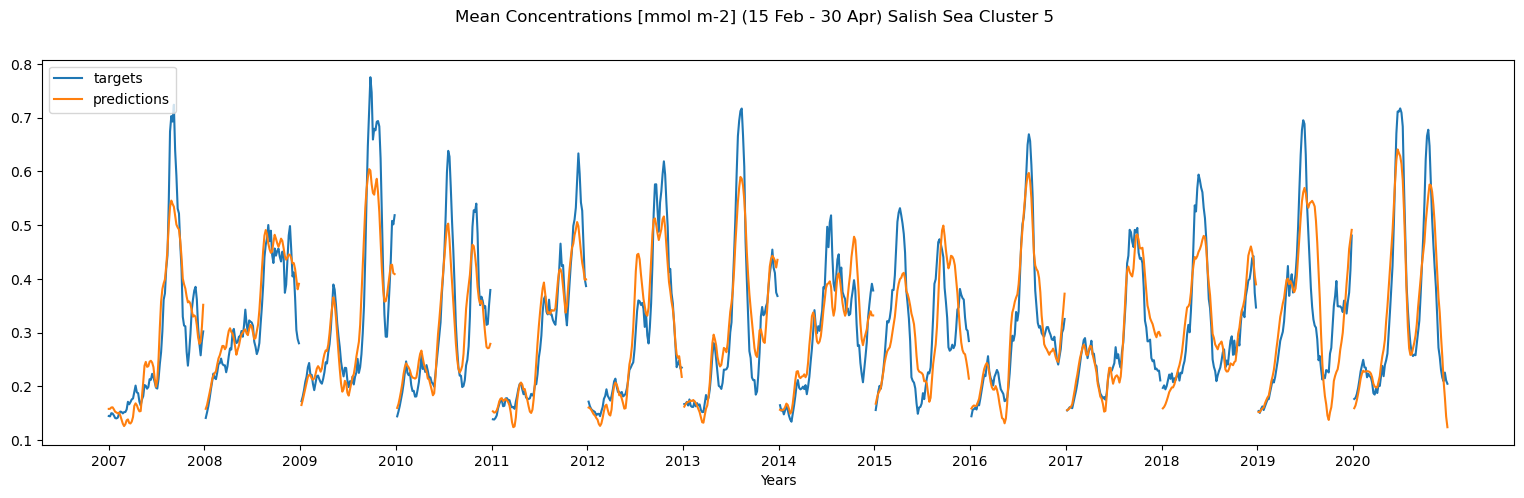

r_train  rms_train  slope_train
Cluster 6    0.863   0.052689        0.744

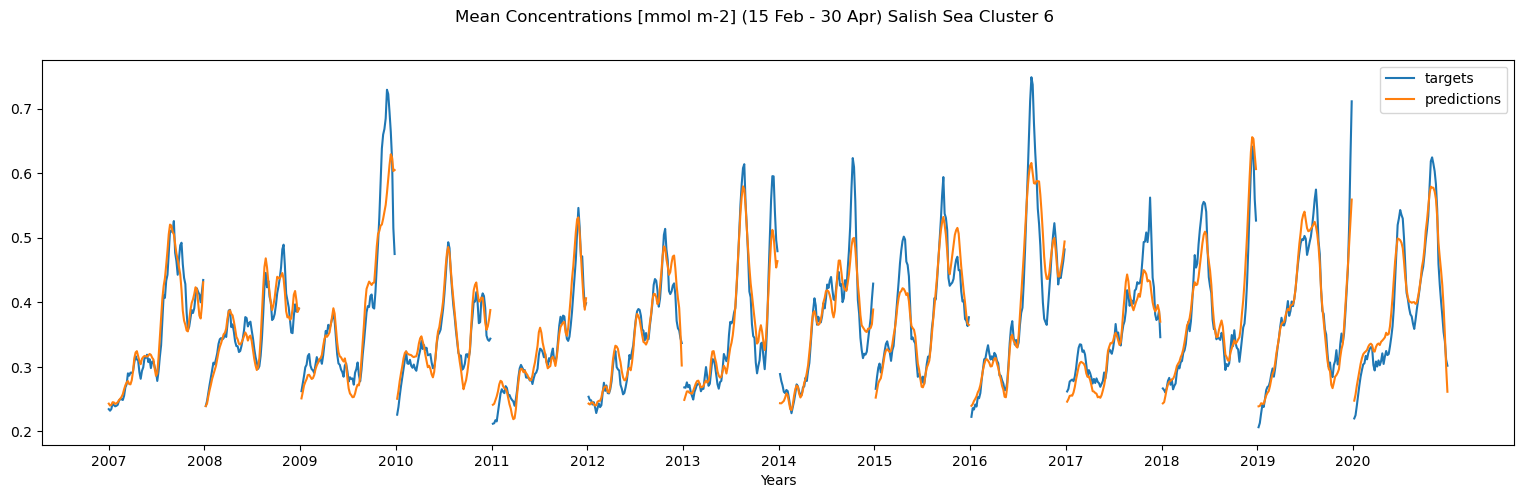

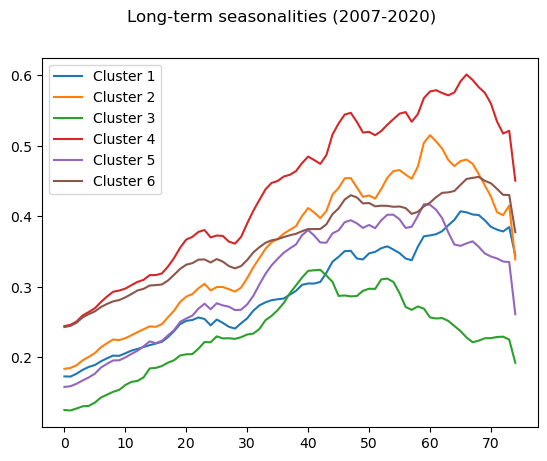

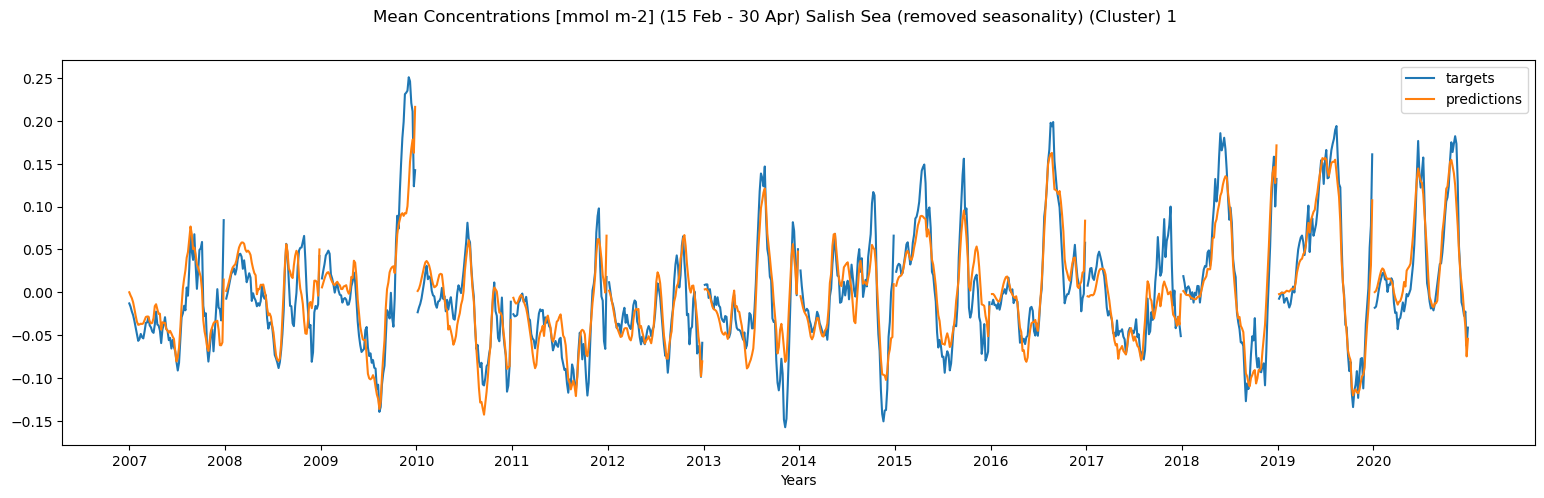

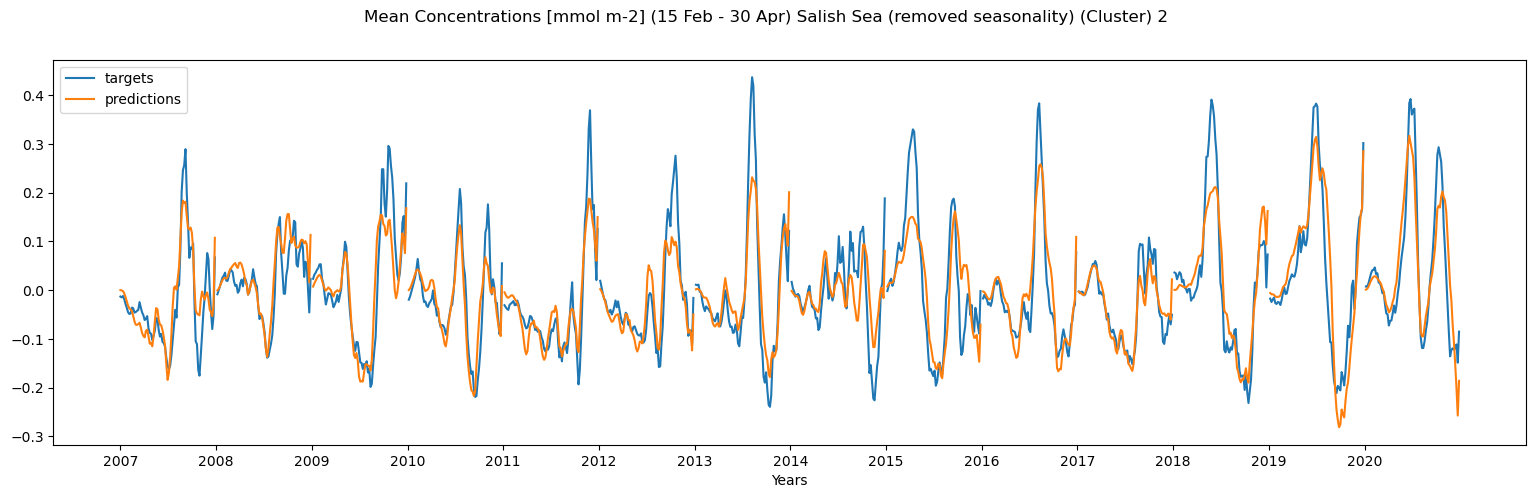

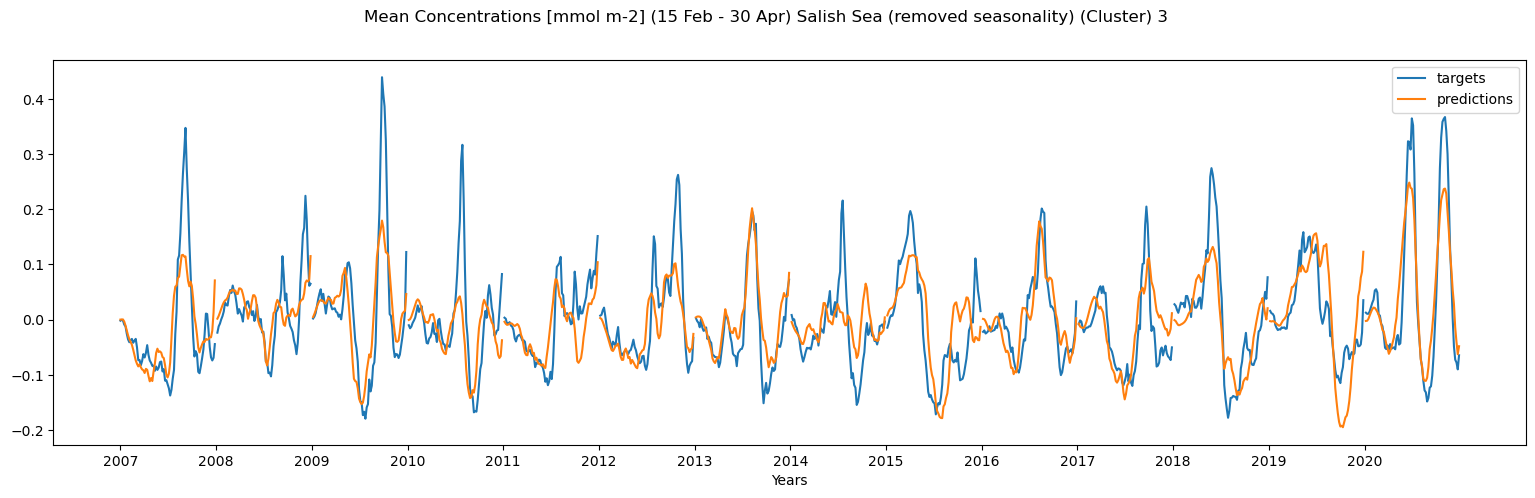

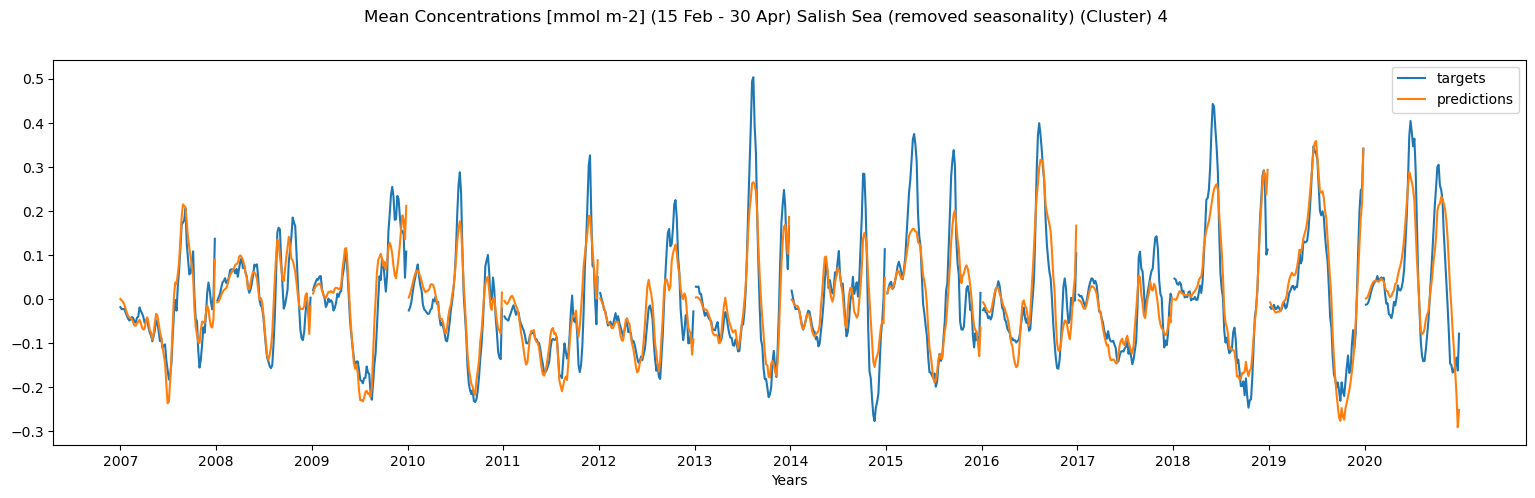

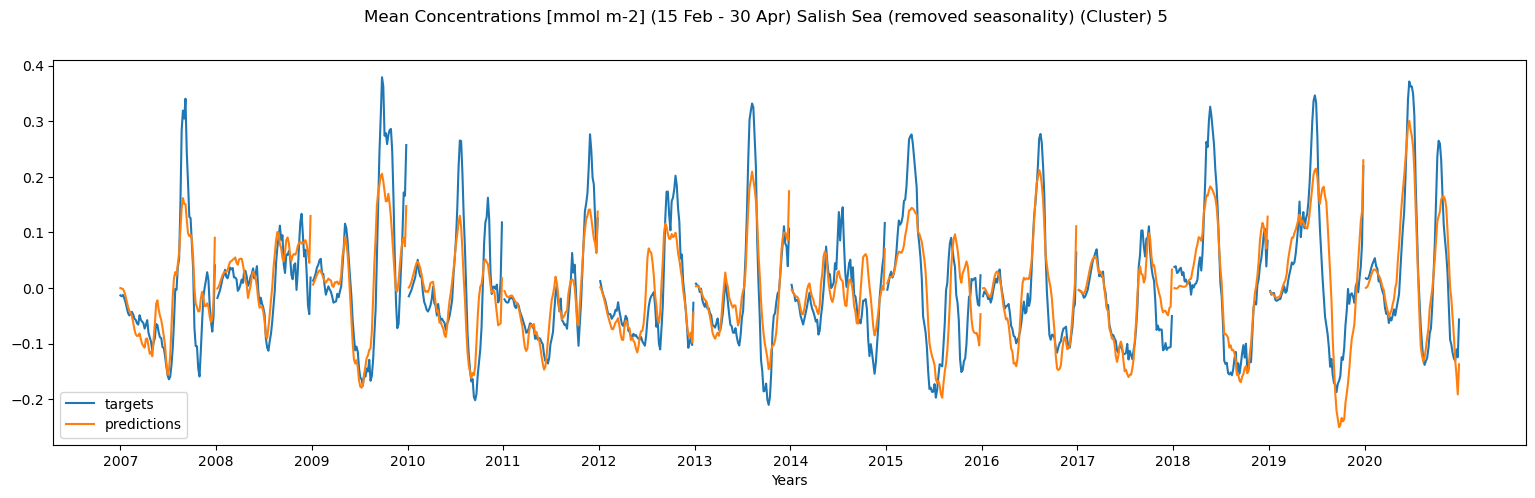

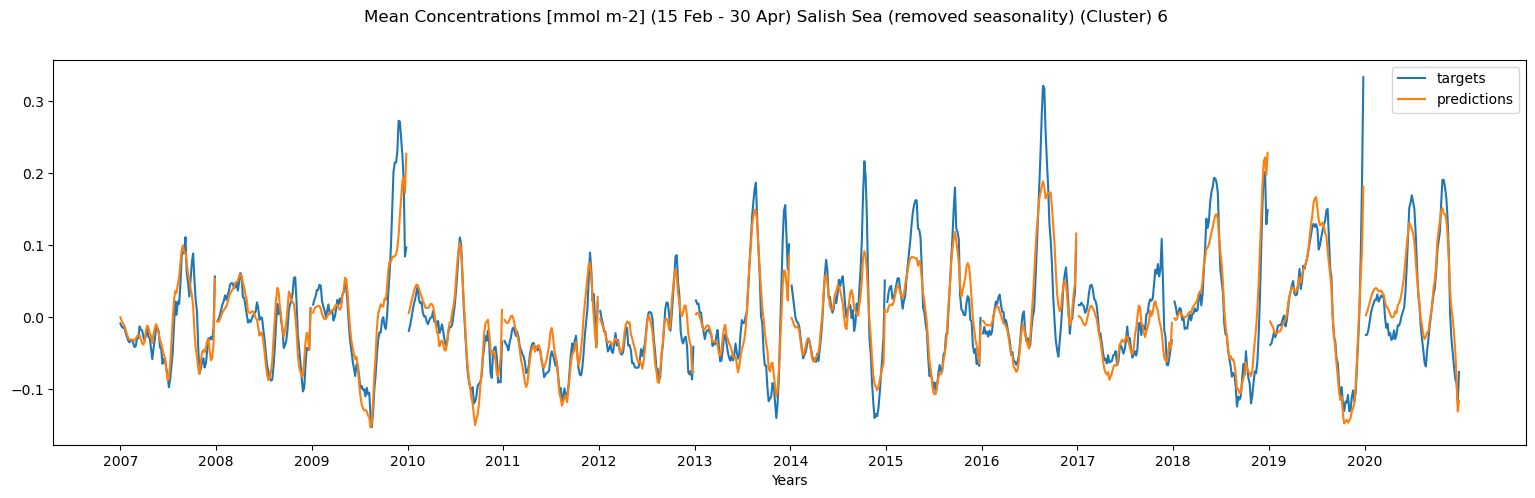

In [18]:
r_train,rms_train,slope_train,targets_mean,predictions_mean = post_processing(dates,dataset,clusters,indx,targets,predictions,units,category)

season = np.zeros((len(np.unique(clusters)),len(dates)))

for i in range (0,len(np.unique(clusters))):

    season[i] = seasonality(dates,targets_mean[i])

plt.plot(season[:,0:75].transpose())
plt.legend(('Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6'))
plt.suptitle('Long-term seasonalities (2007-2020)')

for i in range (0,len(np.unique(clusters))):

    plotting_mean_values(dates, targets_mean[i]-season[i], predictions_mean[i]-season[i], units, category, 'Salish Sea (removed seasonality) (Cluster) '+str(i+1))

quant_train = dataset[name] # Keeping it for the regional seasonalities
dates_season = pd.DatetimeIndex(quant_train['time_counter'].values)


## Other Years

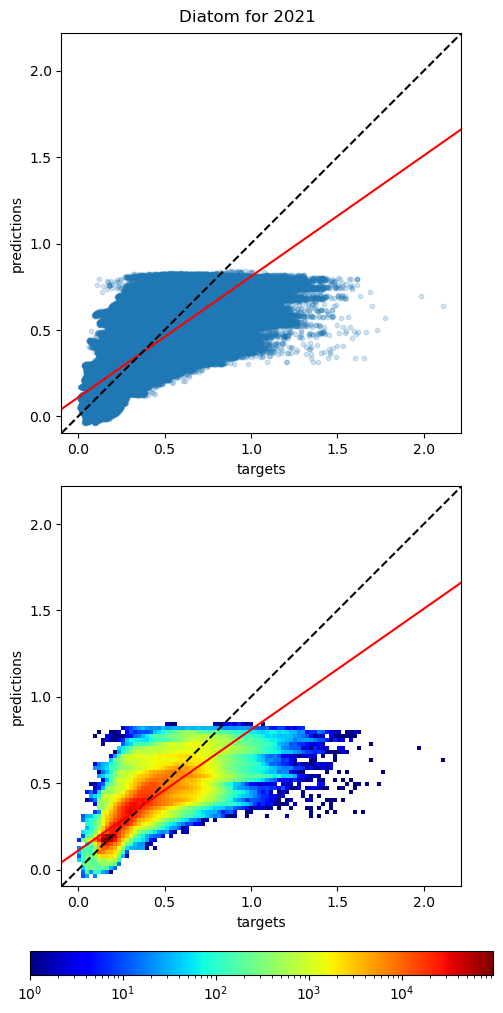

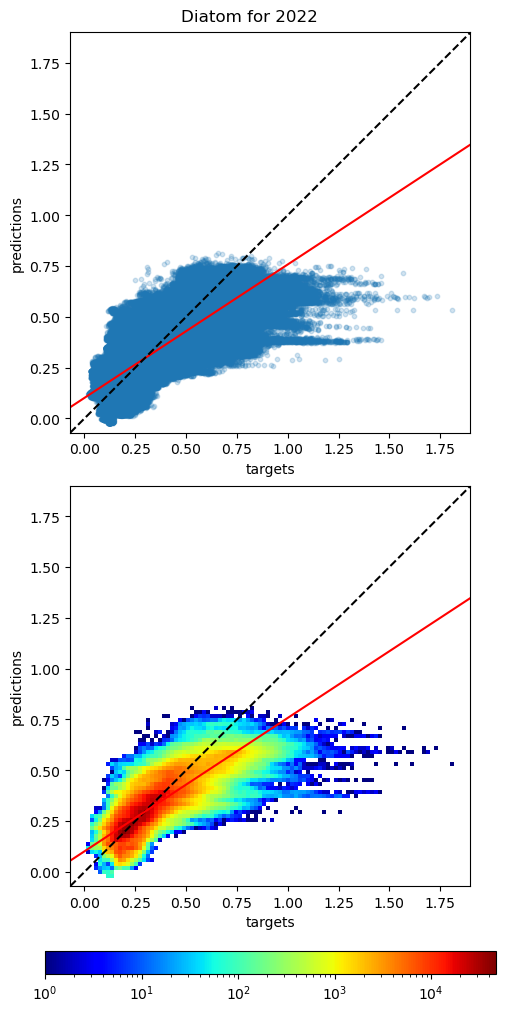

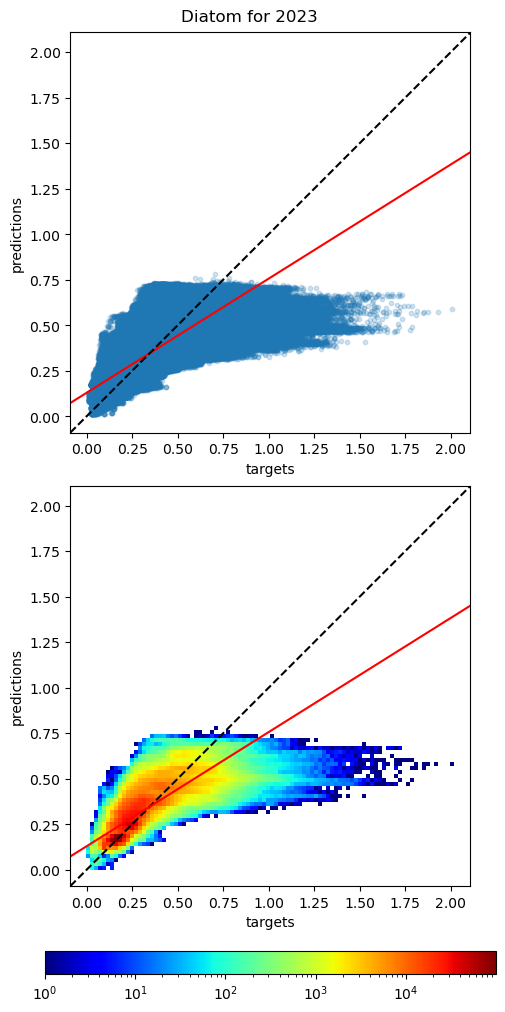

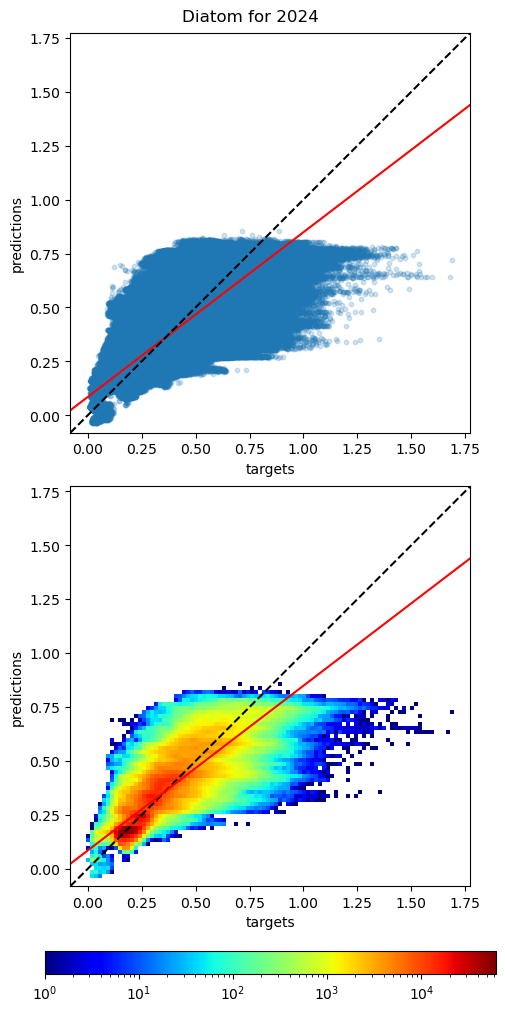

In [19]:
dataset = ds.sel(time_counter = slice('2021', '2024'))
dataset2 = ds2.sel(time_counter = slice('2021', '2024'))

dates = pd.DatetimeIndex(dataset['time_counter'].values)

indx = ~((dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29))
dates = dates[indx]

r_years, rms_years, slope_years, targets_all, predictions_all= evaluation(regr_all, clusters0, dataset,dataset2,name,units,scaler_inputs_all,scaler_targets_all,smoother_all)

r_days = xr.corr(targets_all,predictions_all, dim=['x','y'])
rms_days = xs.rmse(targets_all,predictions_all, dim=['x','y'], skipna=True)
slope_days = xs.linslope(targets_all,predictions_all, dim=['x','y'], skipna=True)


## Plotting (Results)

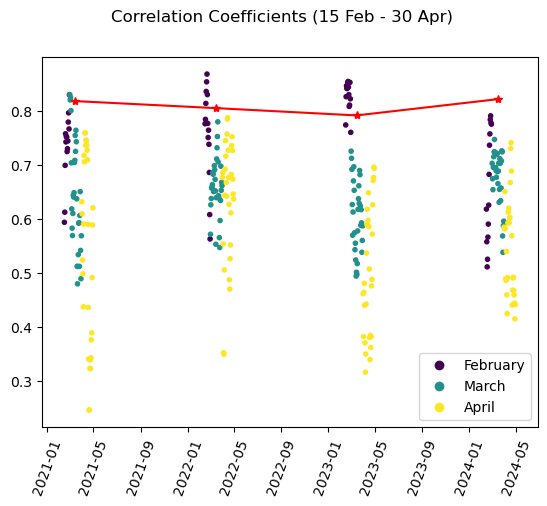

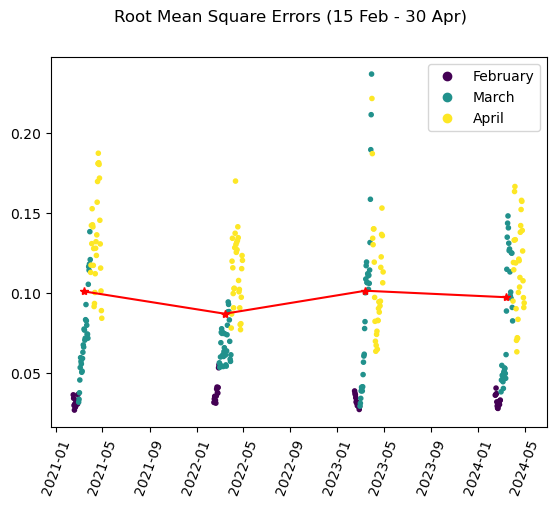

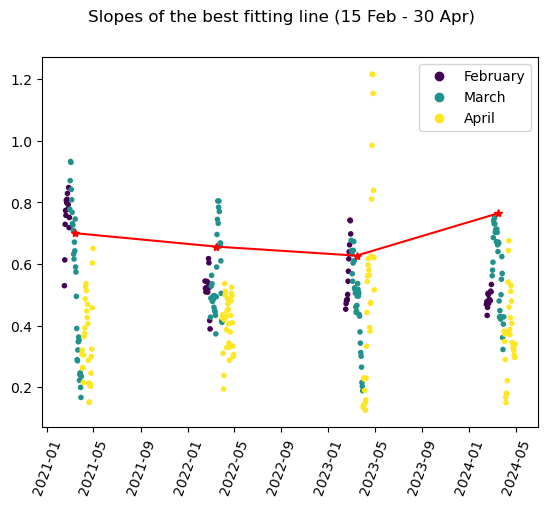

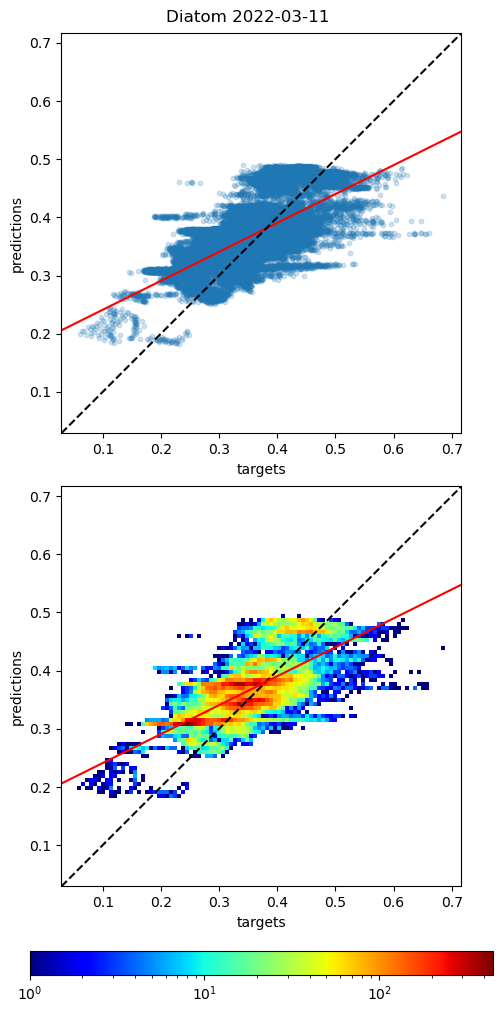

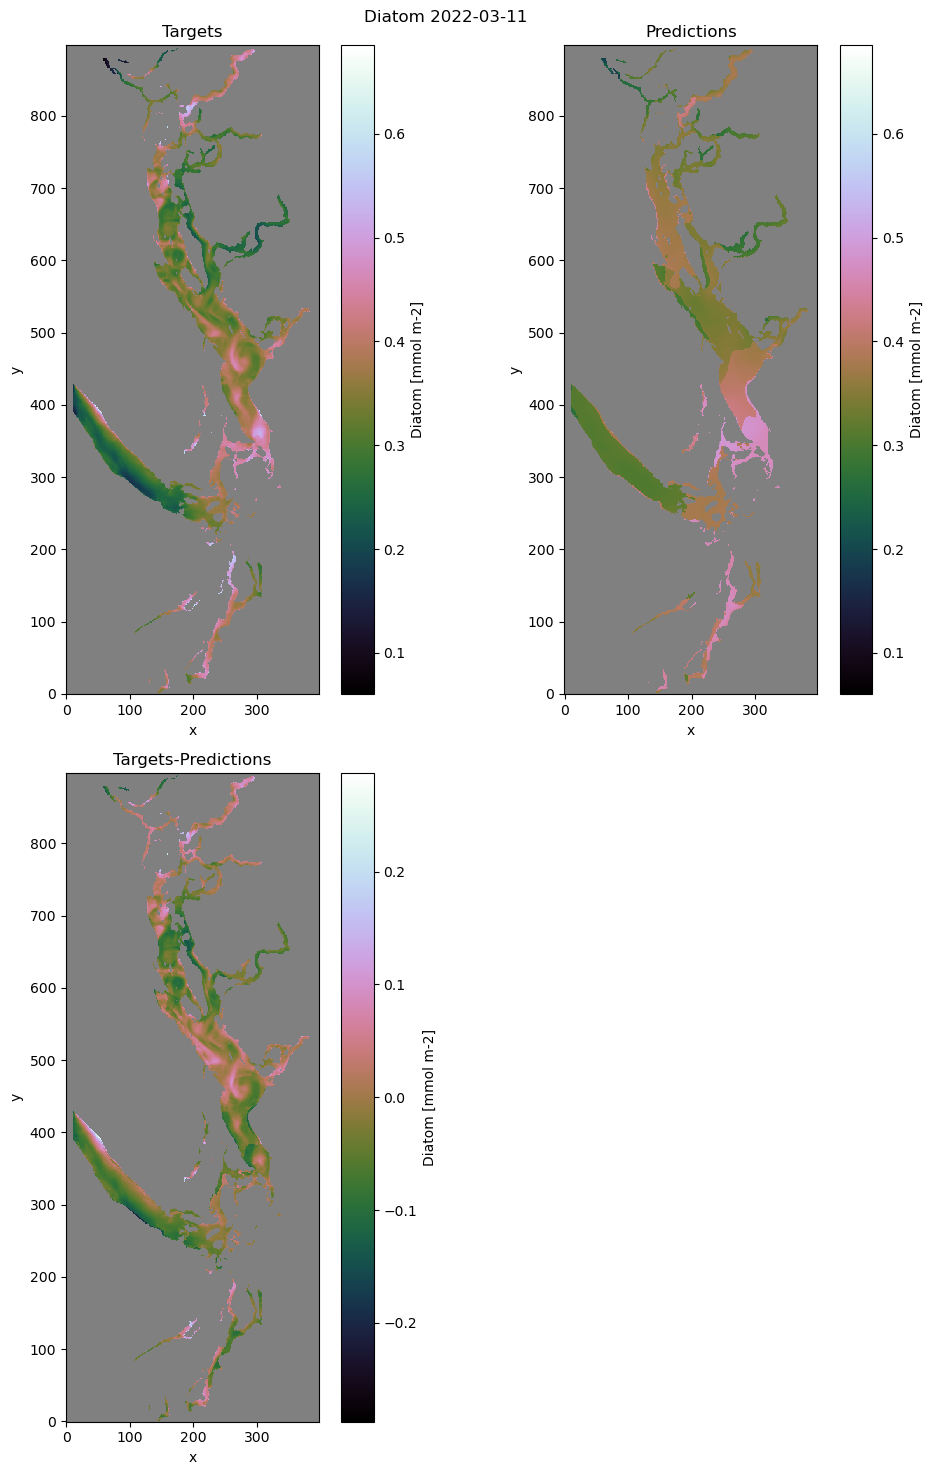

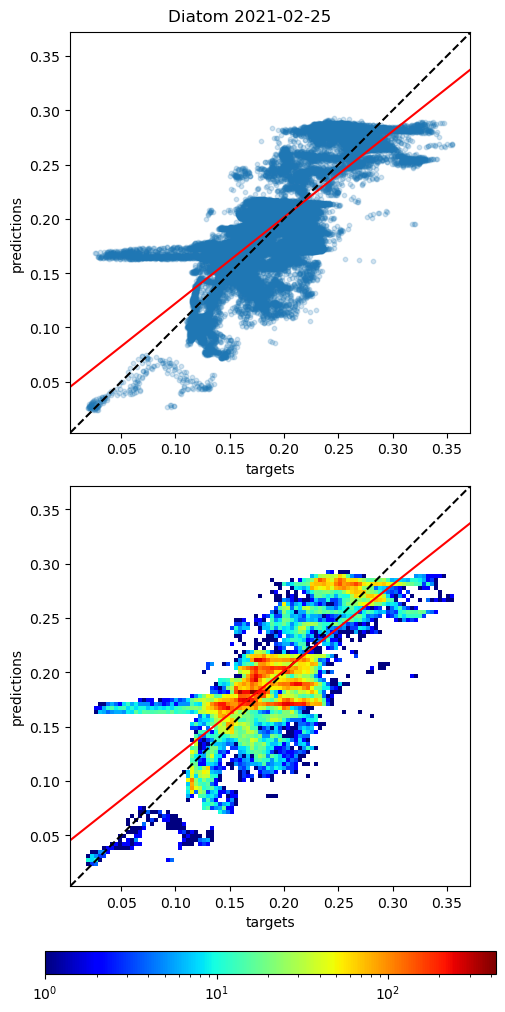

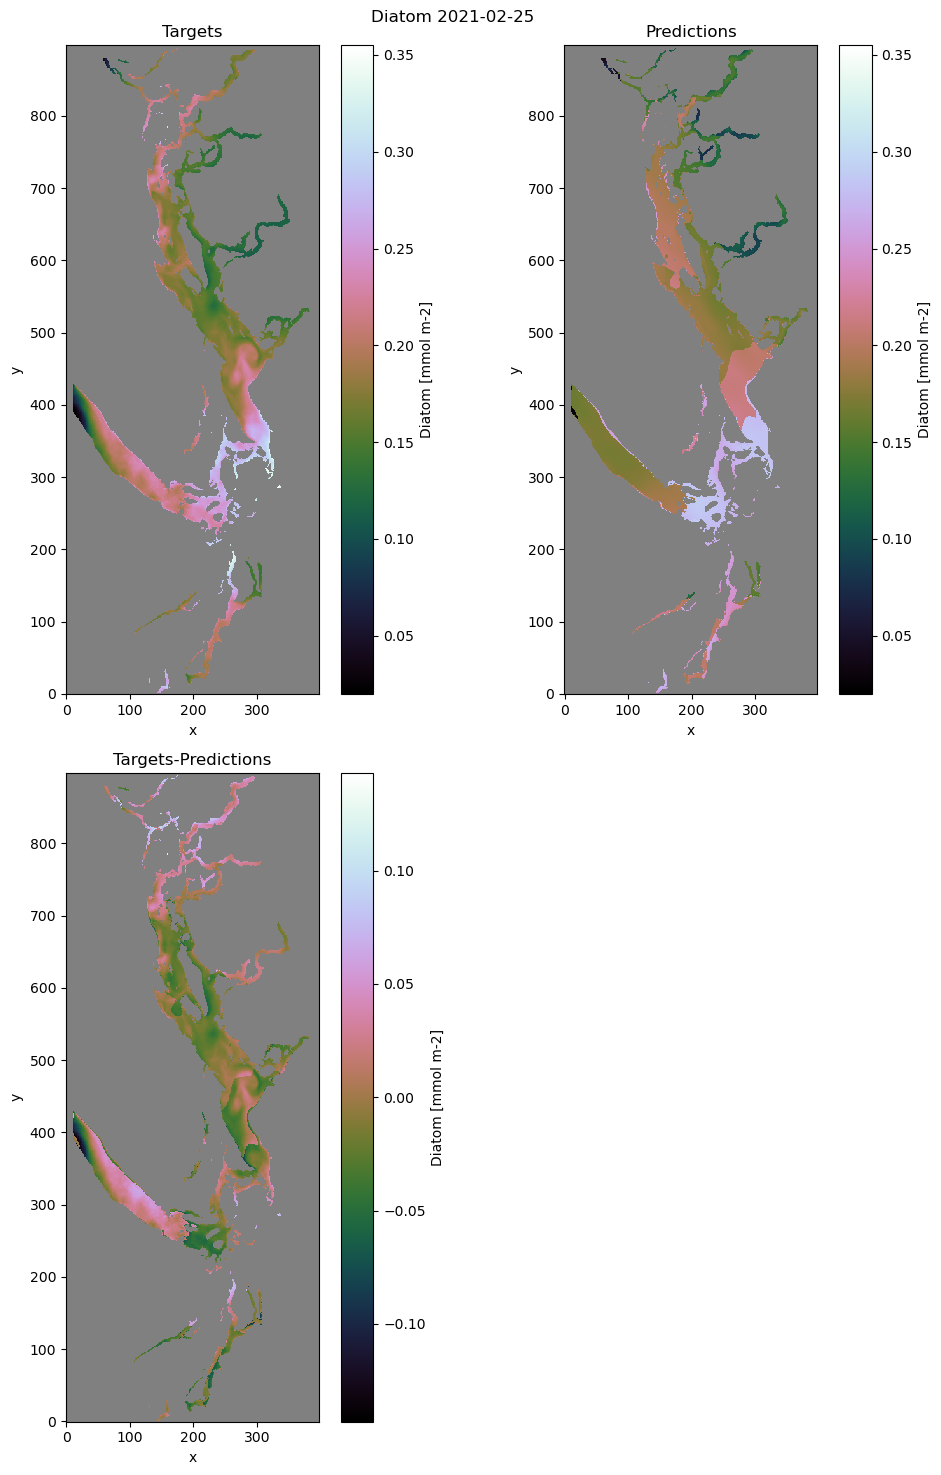

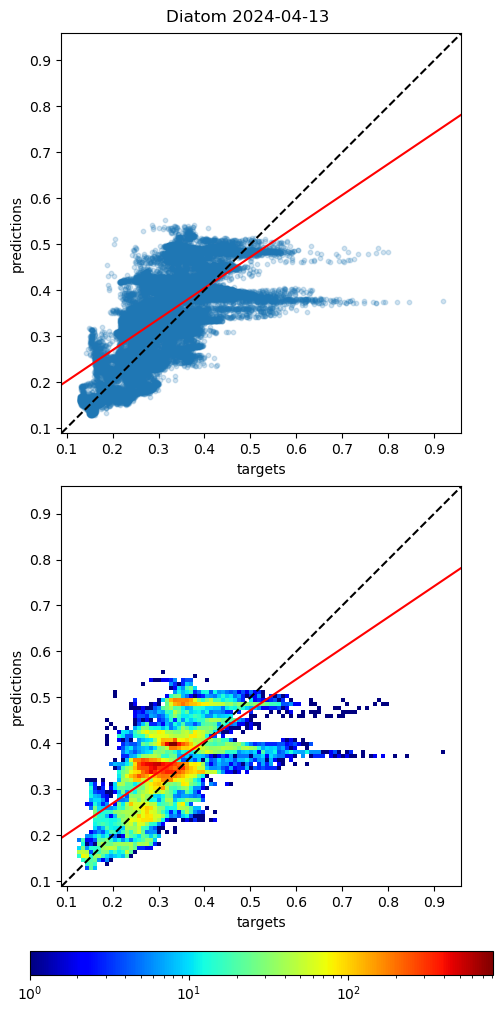

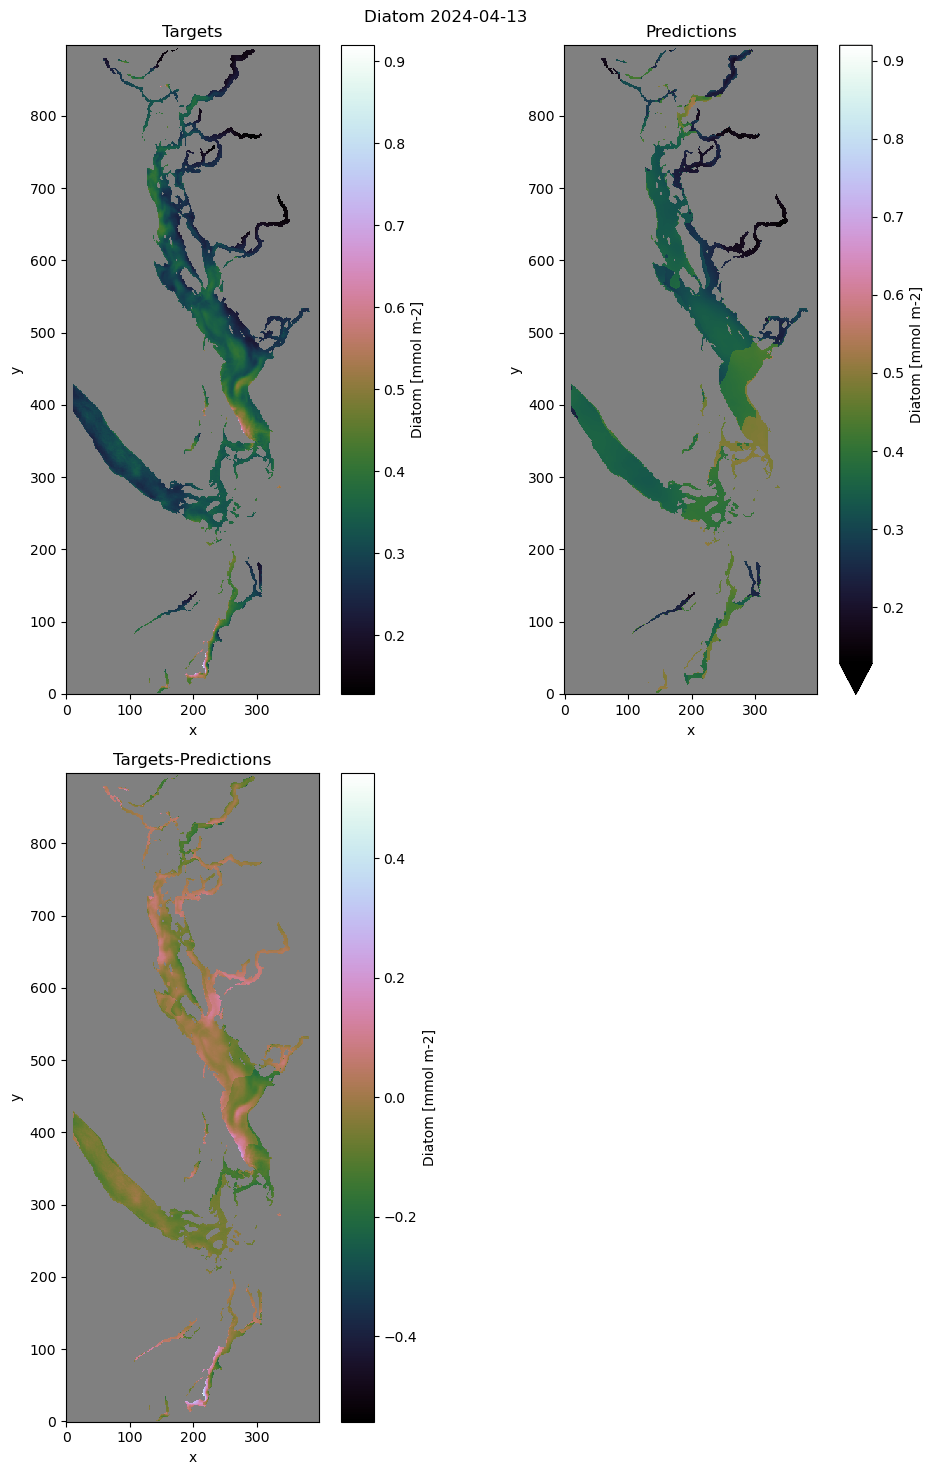

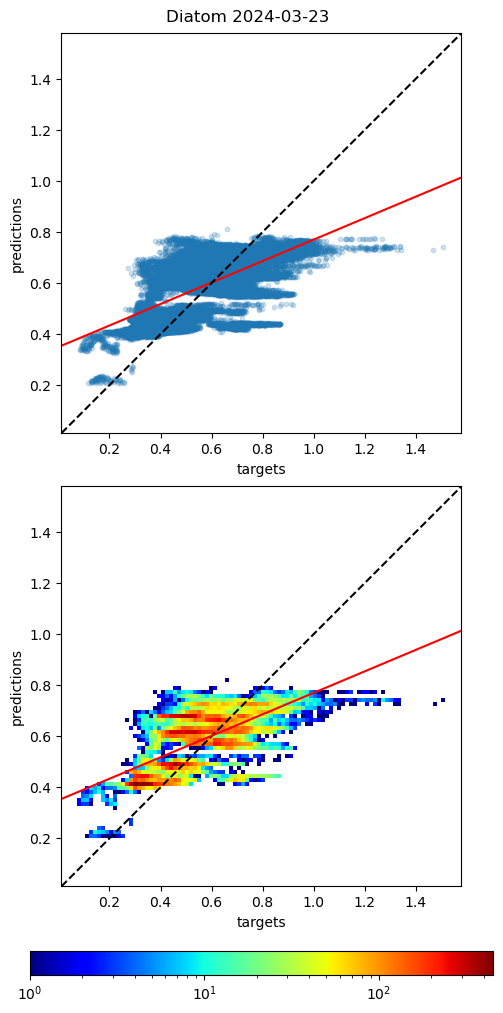

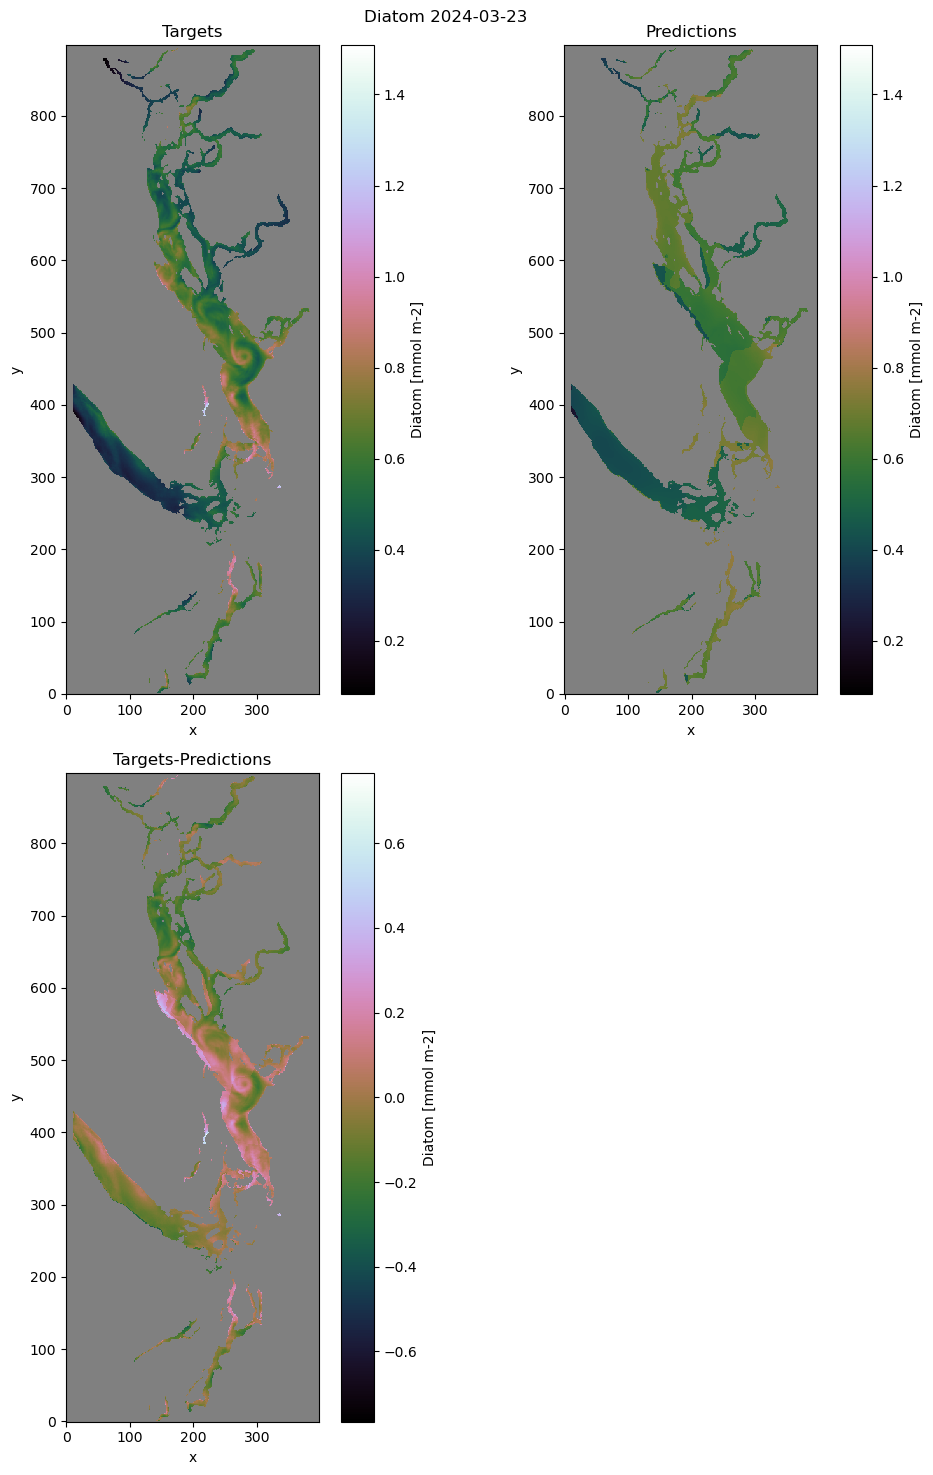

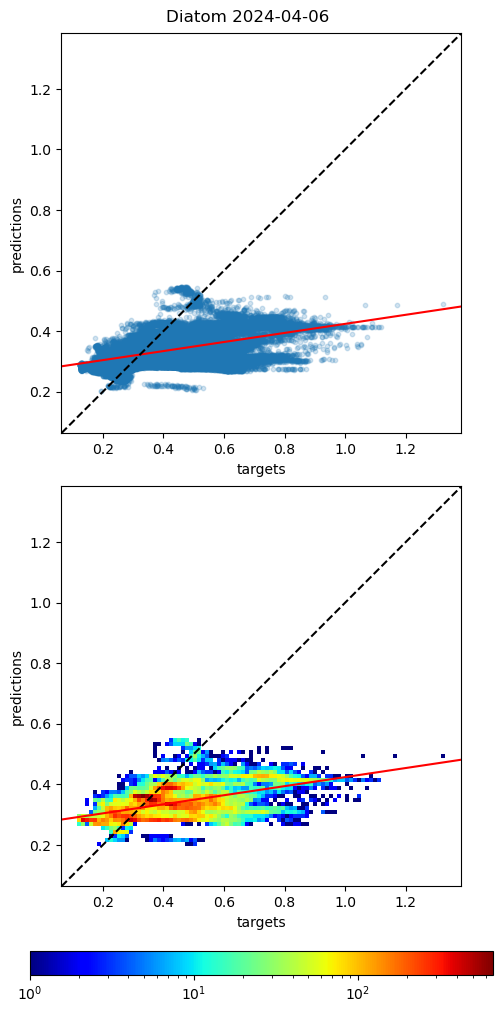

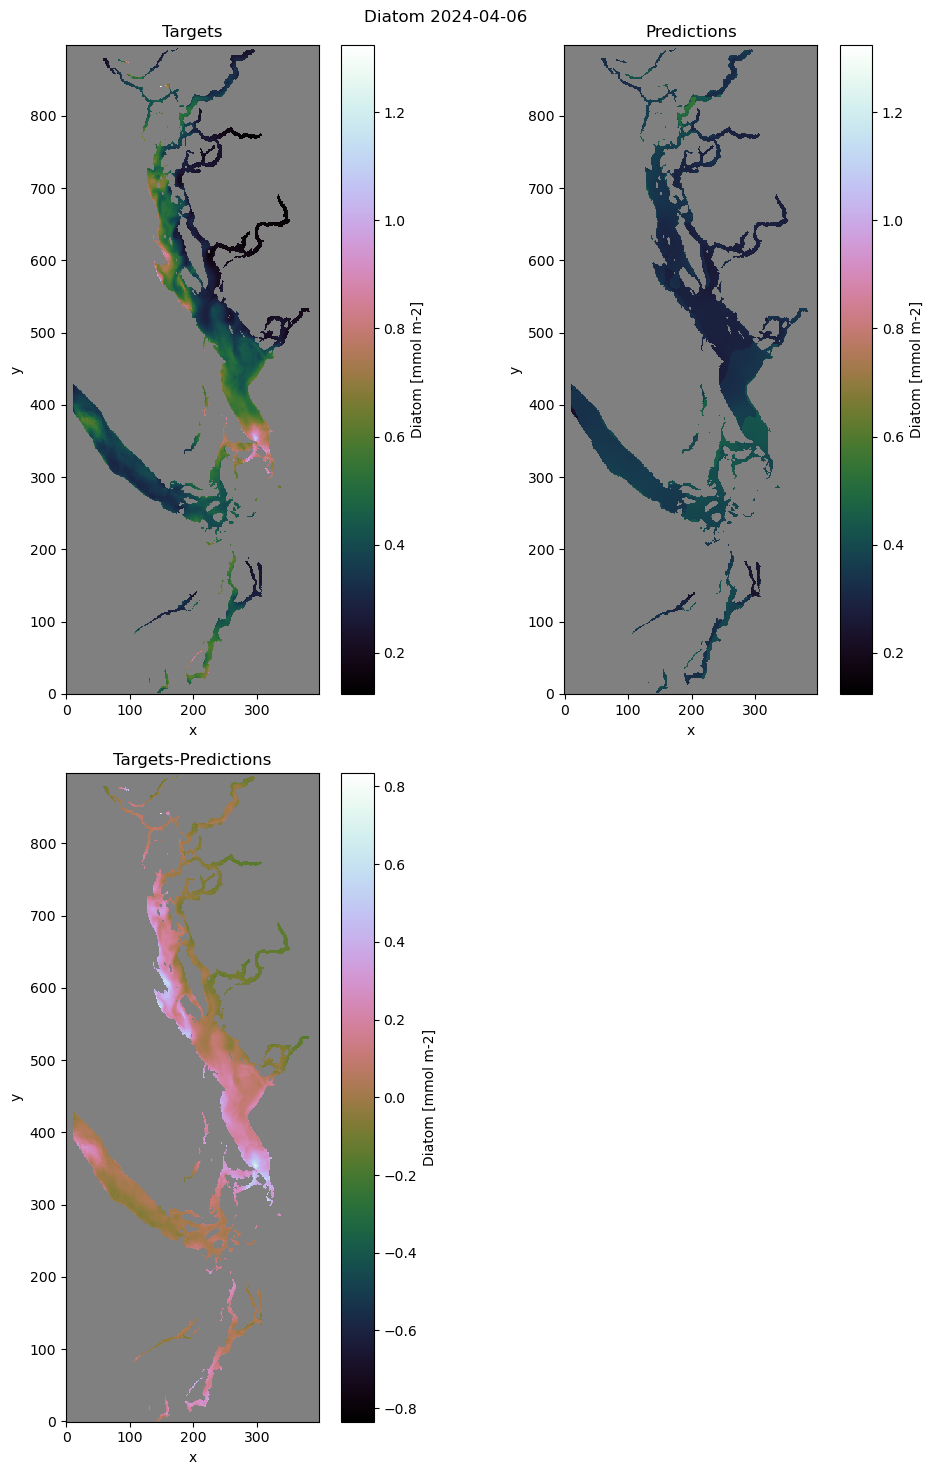

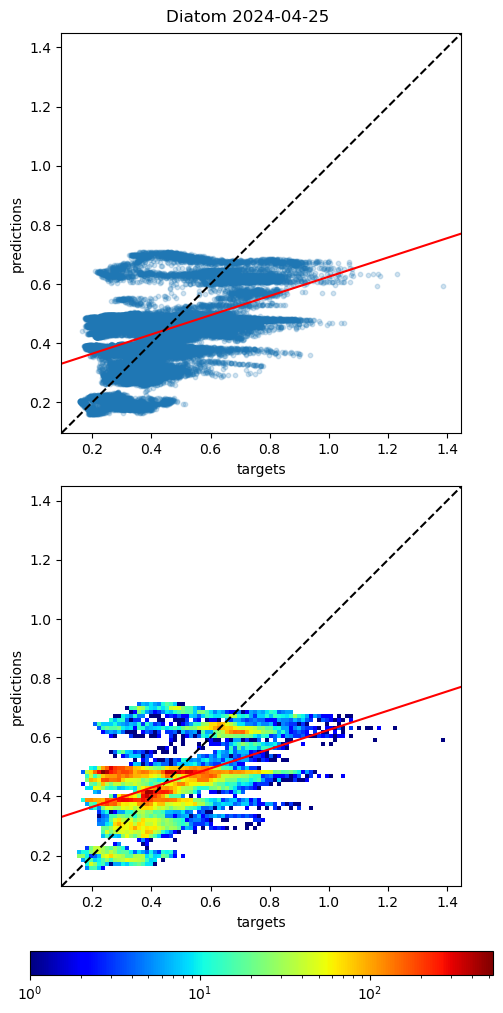

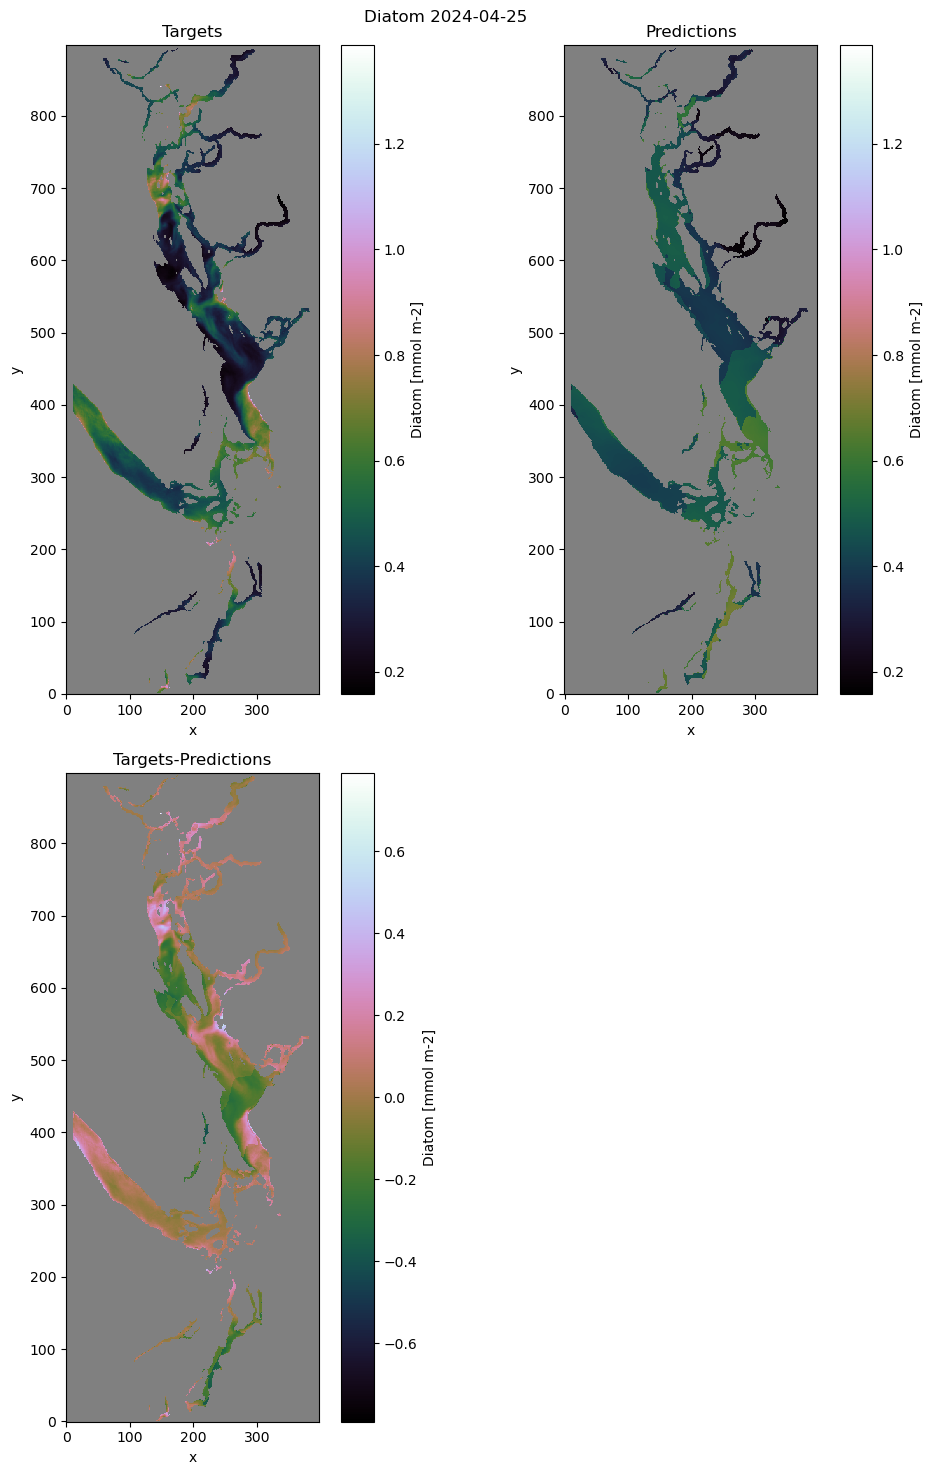

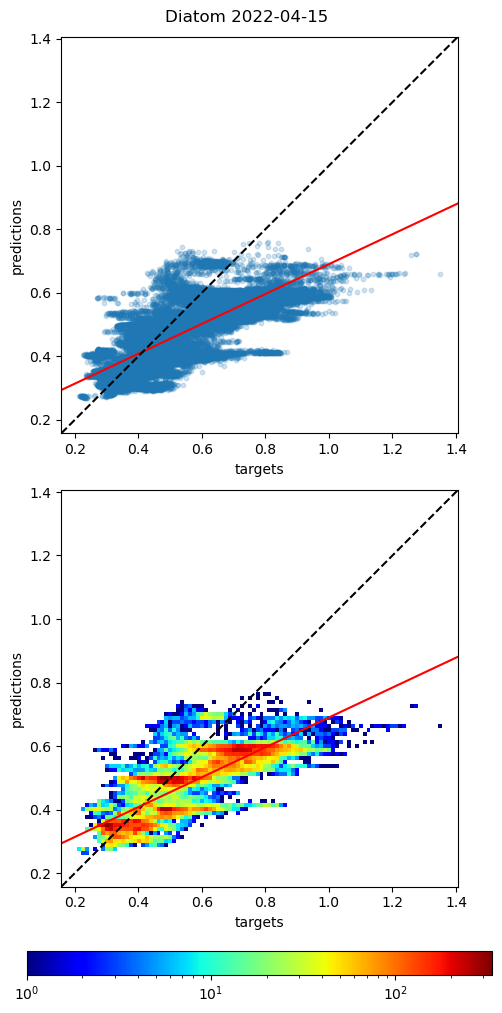

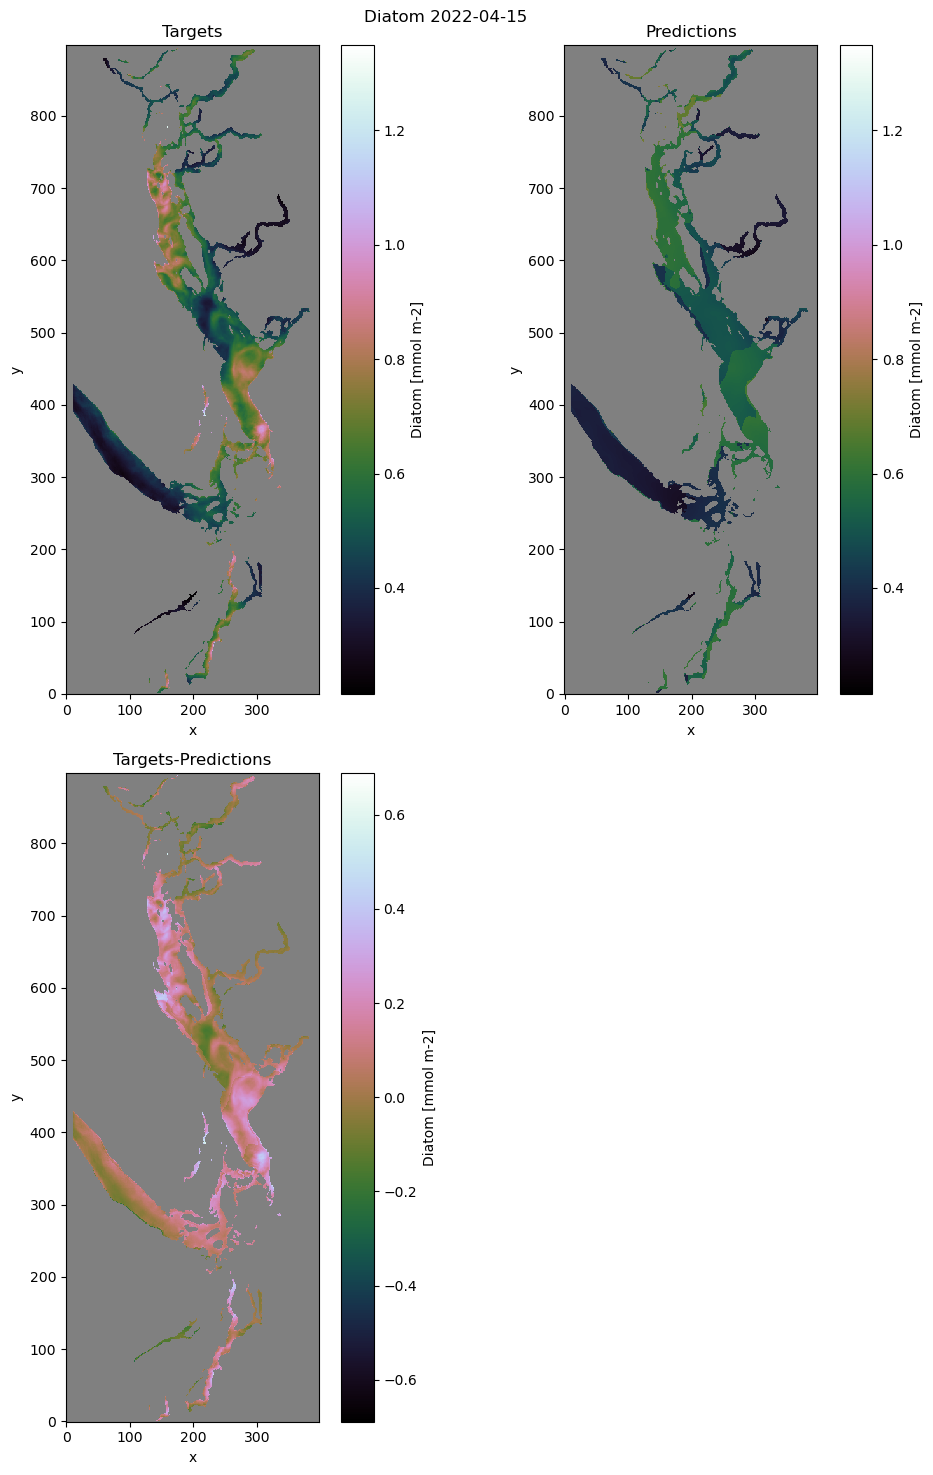

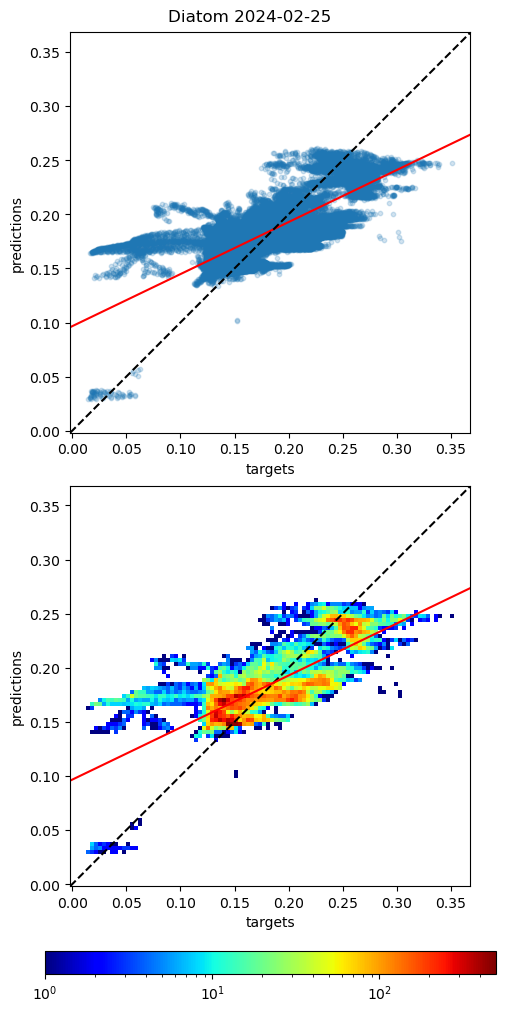

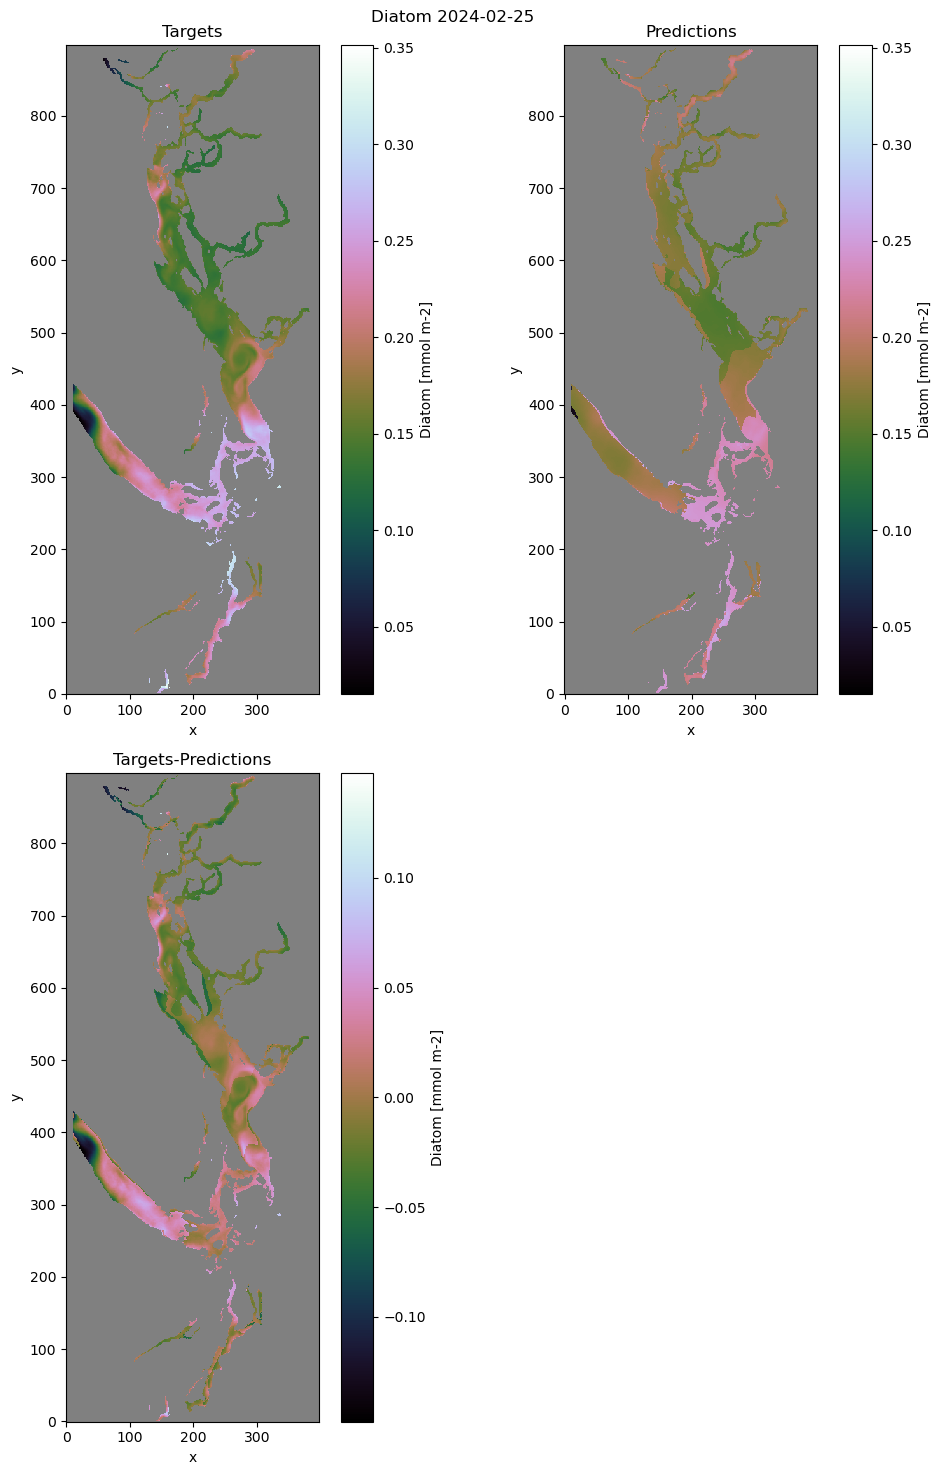

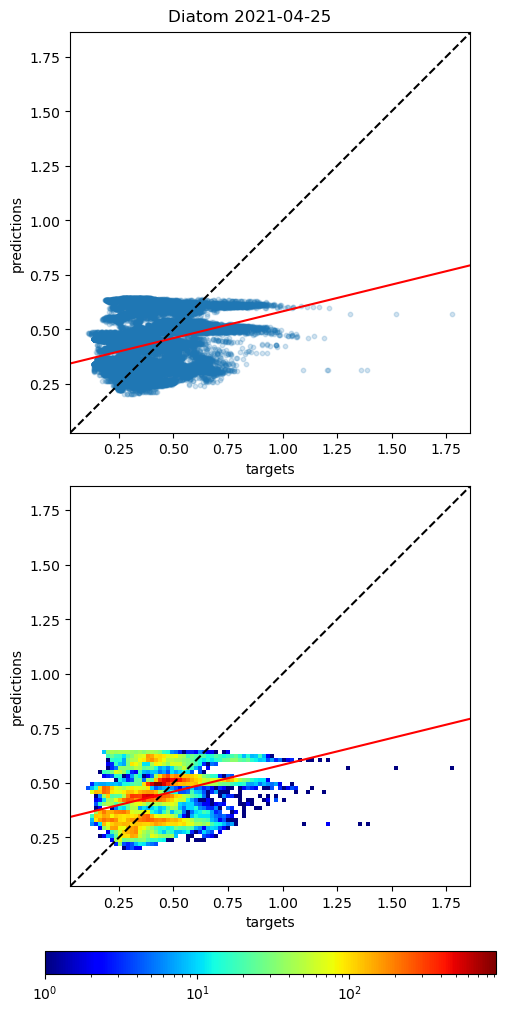

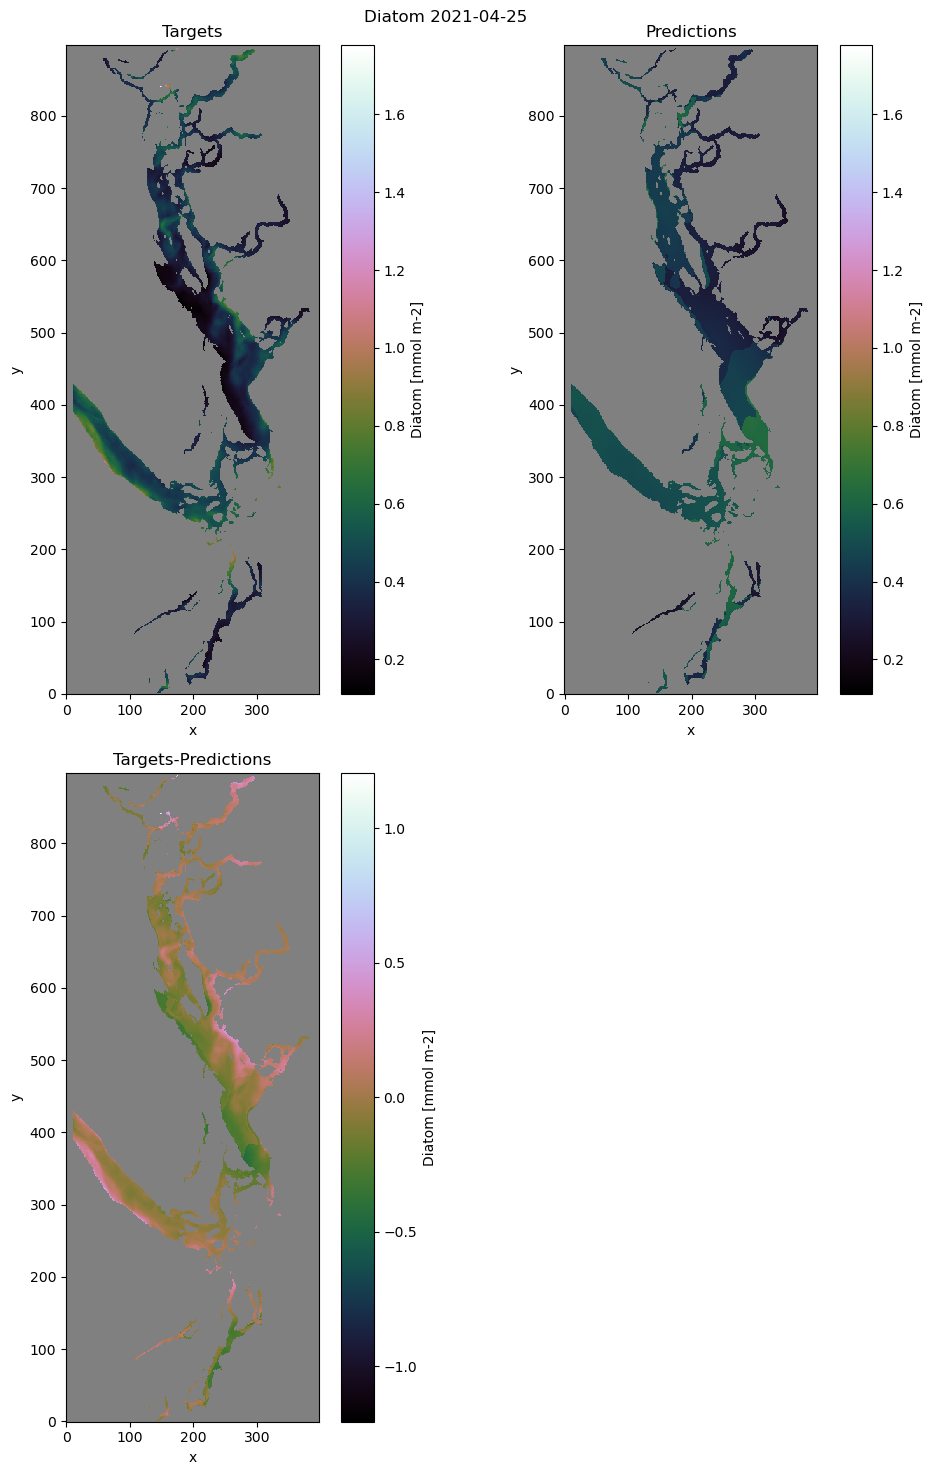

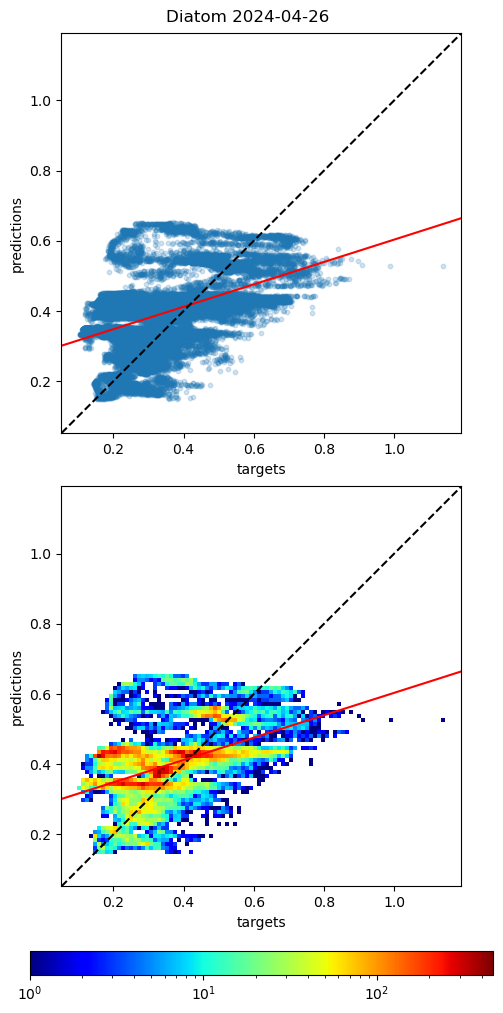

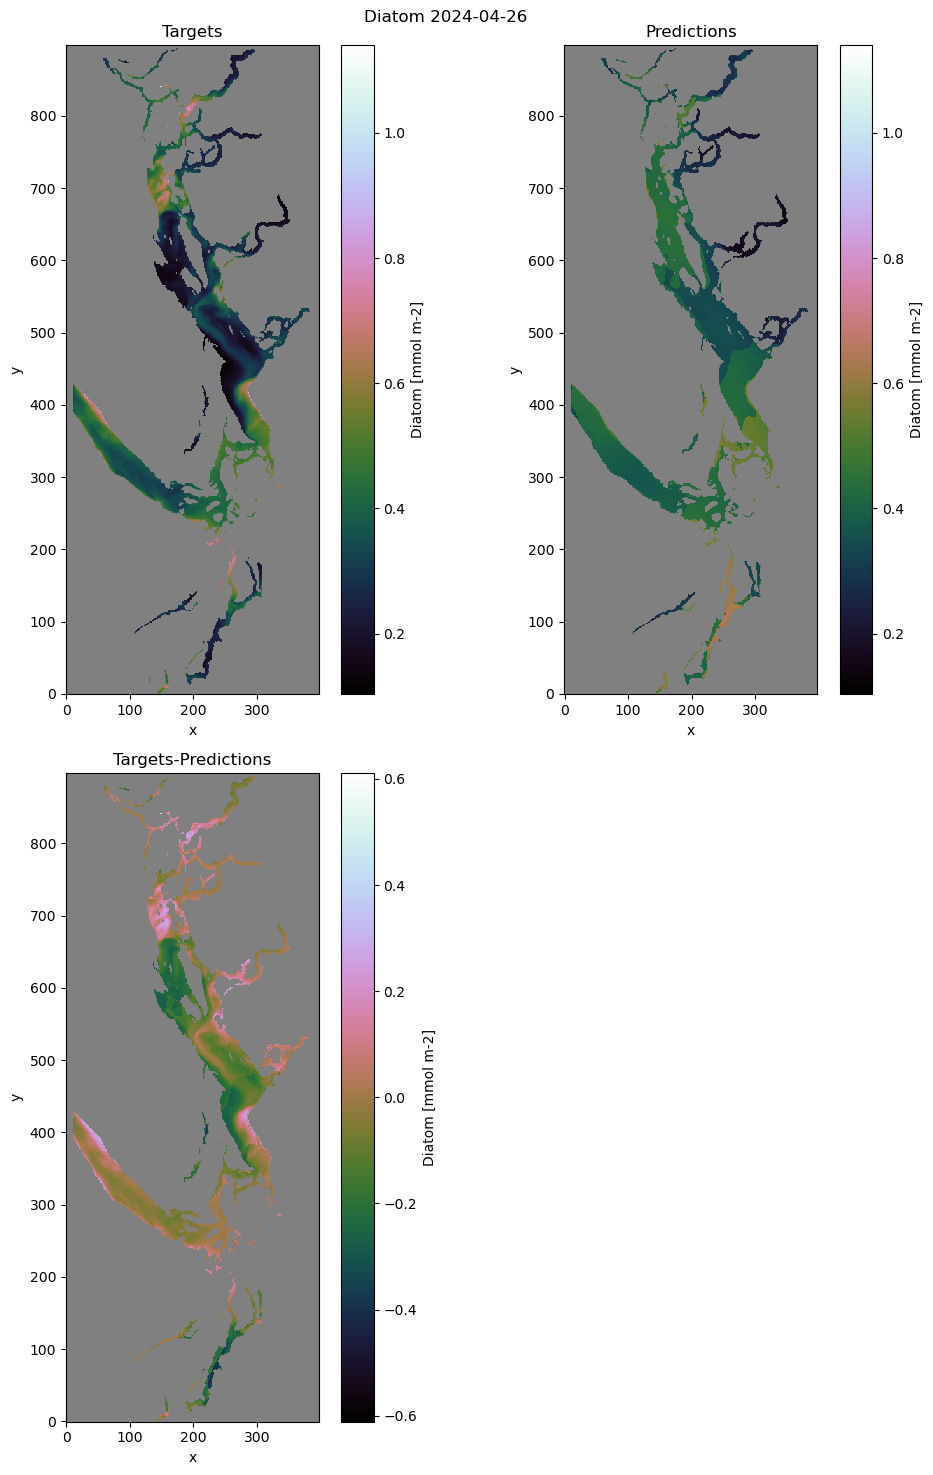

In [20]:
plotting_criteria(dates, r_days, r_years, 'Correlation Coefficients')
plotting_criteria(dates, rms_days, rms_years, 'Root Mean Square Errors')
plotting_criteria(dates, slope_days, slope_years, 'Slopes of the best fitting line')

# Daily maps
maps = random.sample(sorted(np.arange(0,len(targets_all.time_counter))),10)
for i in maps:

    idx = np.isfinite(np.ravel(targets_all[i]))
    scatter_plot(np.ravel(targets_all[i])[idx], np.ravel(predictions_all[i])[idx], name + ' '+ str(targets_all[i].time_counter.dt.date.values))

    plotting_maps(targets_all[i], predictions_all[i], name, units)
    

## Time-series

r_test  rms_test  slope_test
2021   0.974  0.020185       0.998
2022   0.908  0.025191       0.997
2023   0.925  0.024945       0.992
2024   0.938  0.029008       0.903

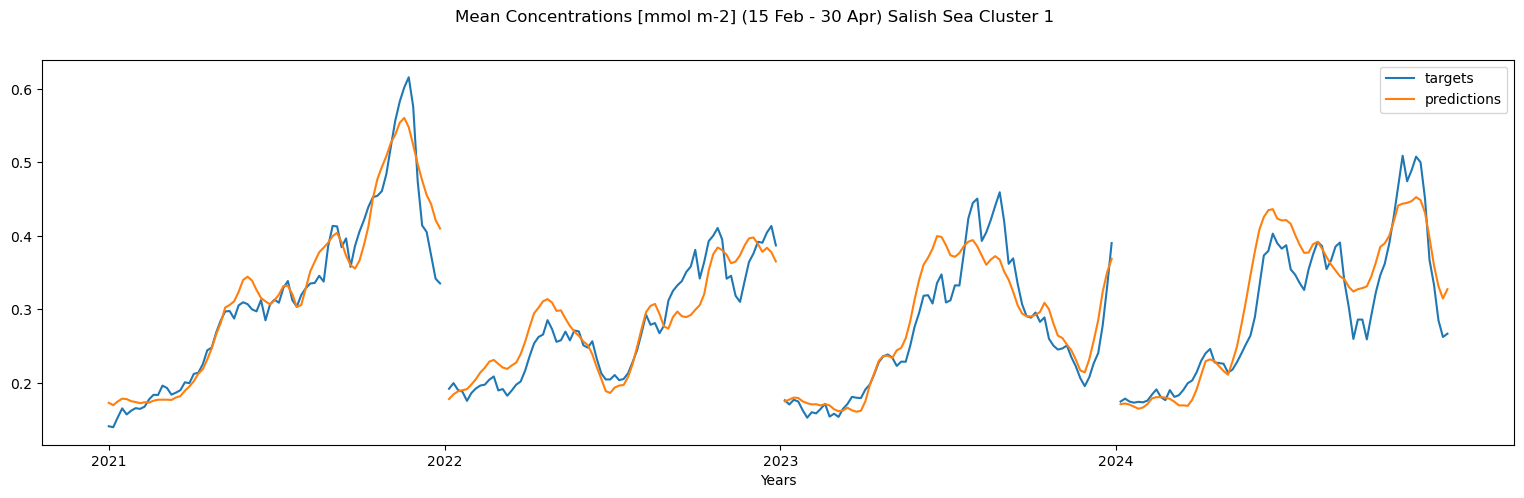

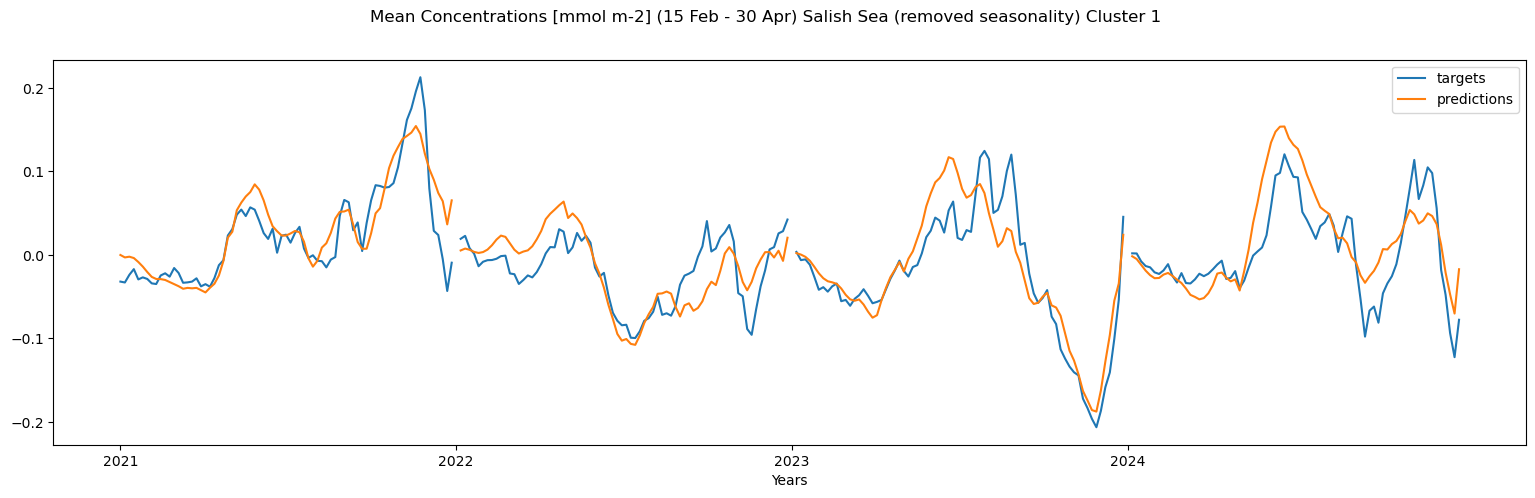

r_test  rms_test  slope_test
2021   0.938  0.040825       0.965
2022   0.917  0.044997       0.972
2023   0.844  0.070806       1.047
2024   0.926  0.048734       0.839

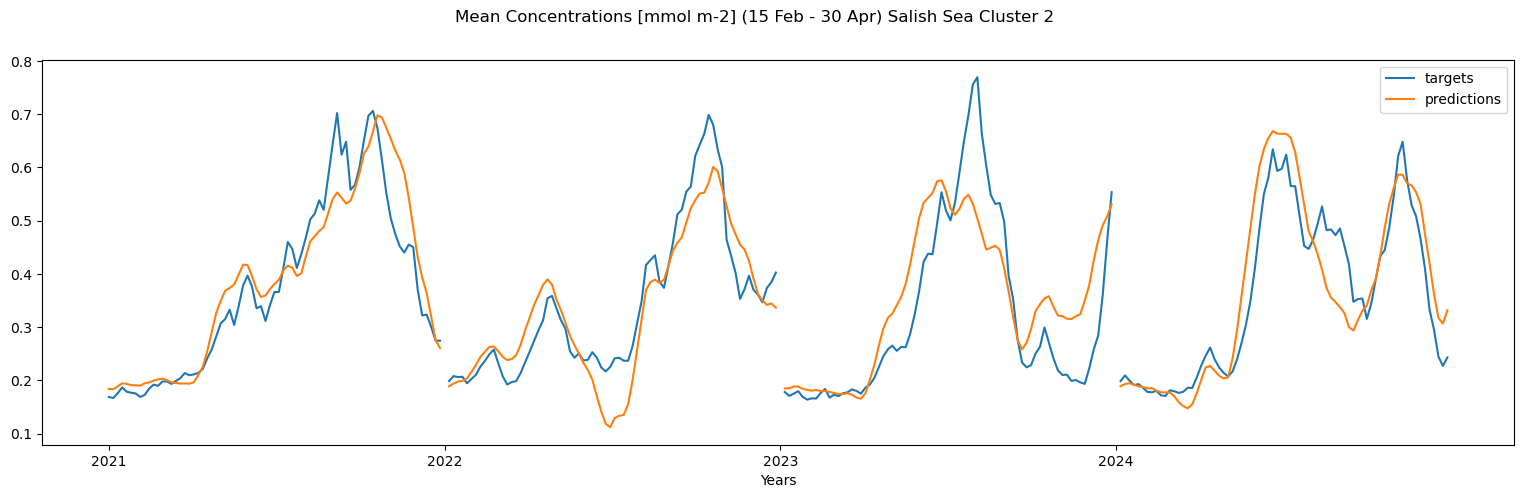

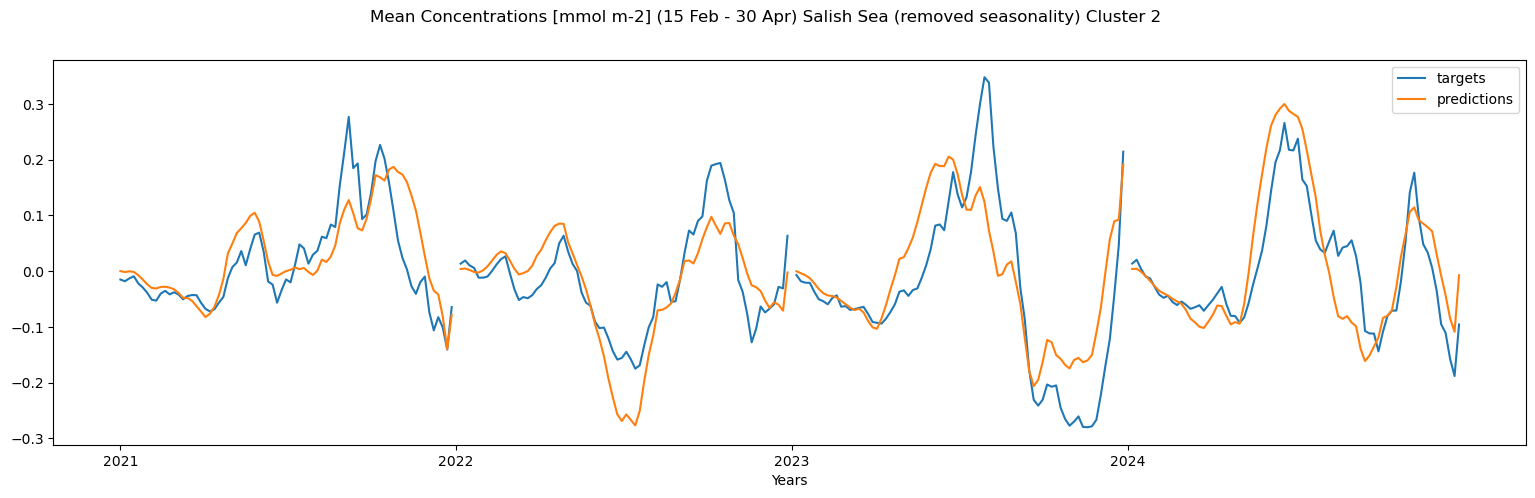

r_test  rms_test  slope_test
2021   0.904  0.041529       0.946
2022   0.763  0.042050       0.916
2023   0.948  0.031678       1.108
2024   0.861  0.041267       0.821

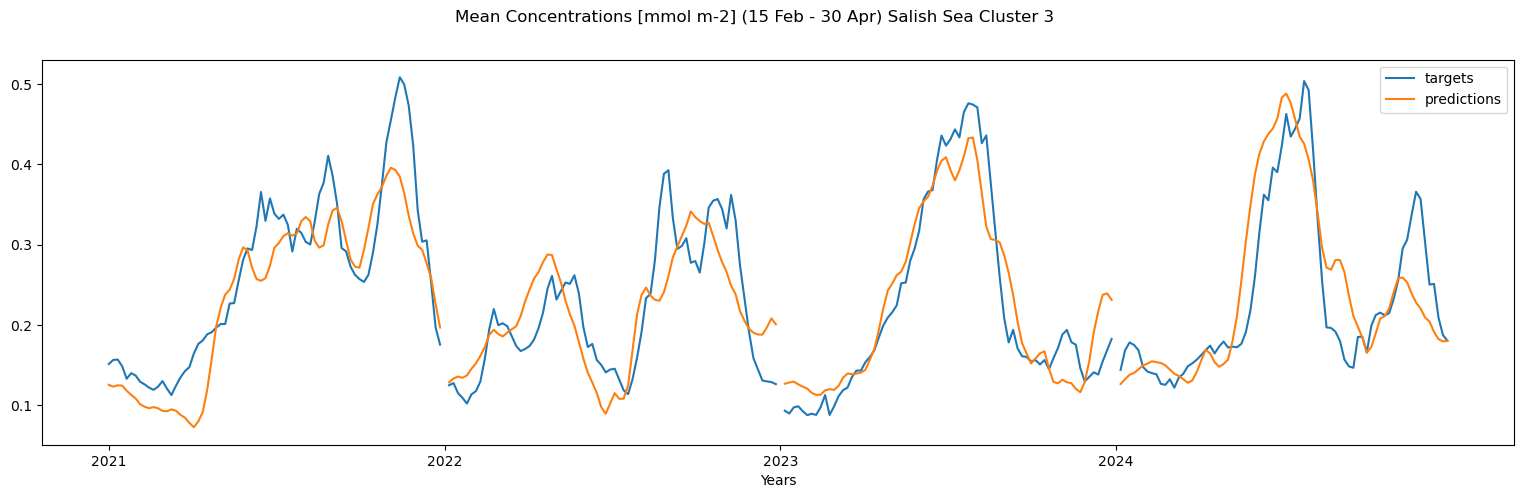

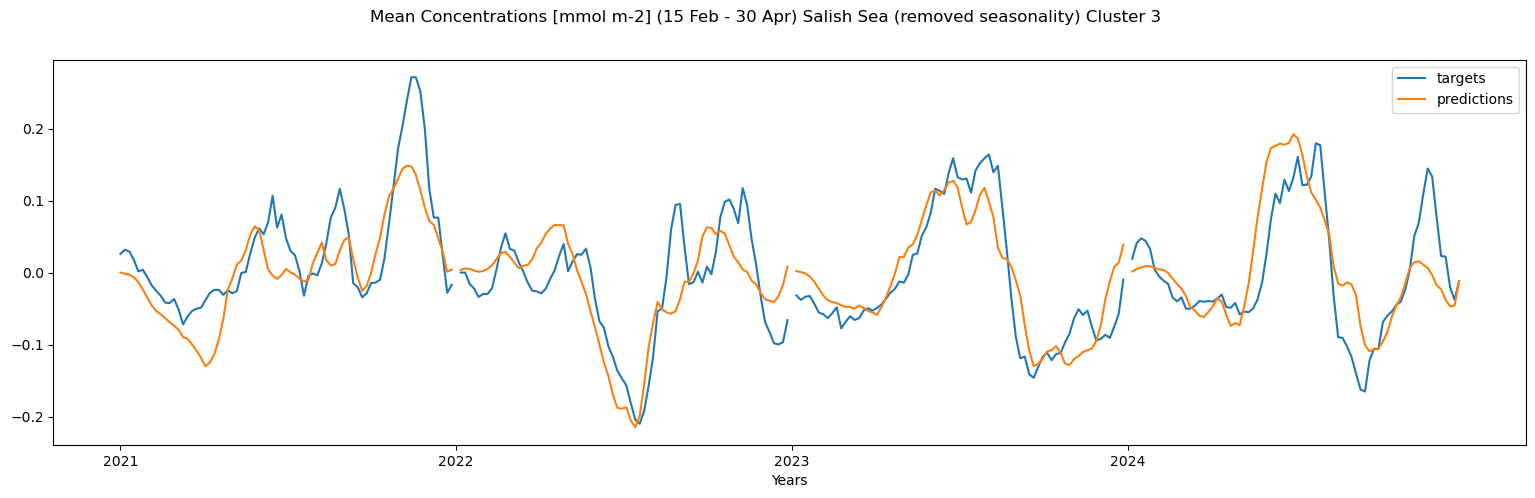

r_test  rms_test  slope_test
2021   0.921  0.048996       0.950
2022   0.916  0.049981       1.067
2023   0.862  0.064636       0.976
2024   0.924  0.047617       0.943

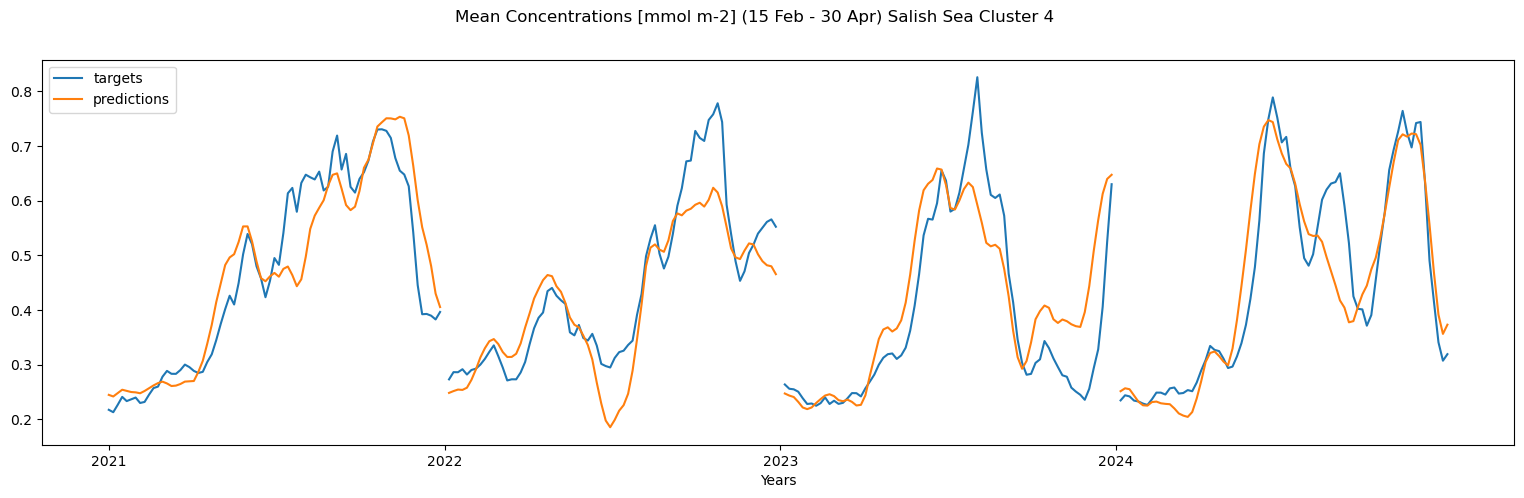

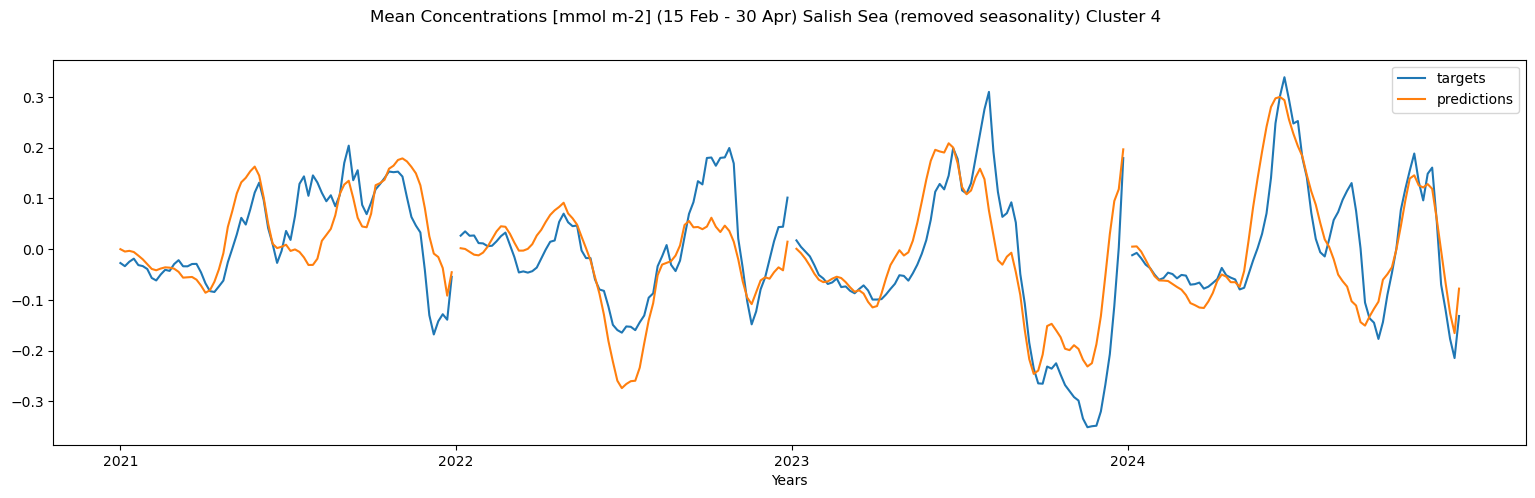

r_test  rms_test  slope_test
2021   0.954  0.027491       1.019
2022   0.909  0.035172       0.887
2023   0.918  0.049694       1.146
2024   0.931  0.040205       0.865

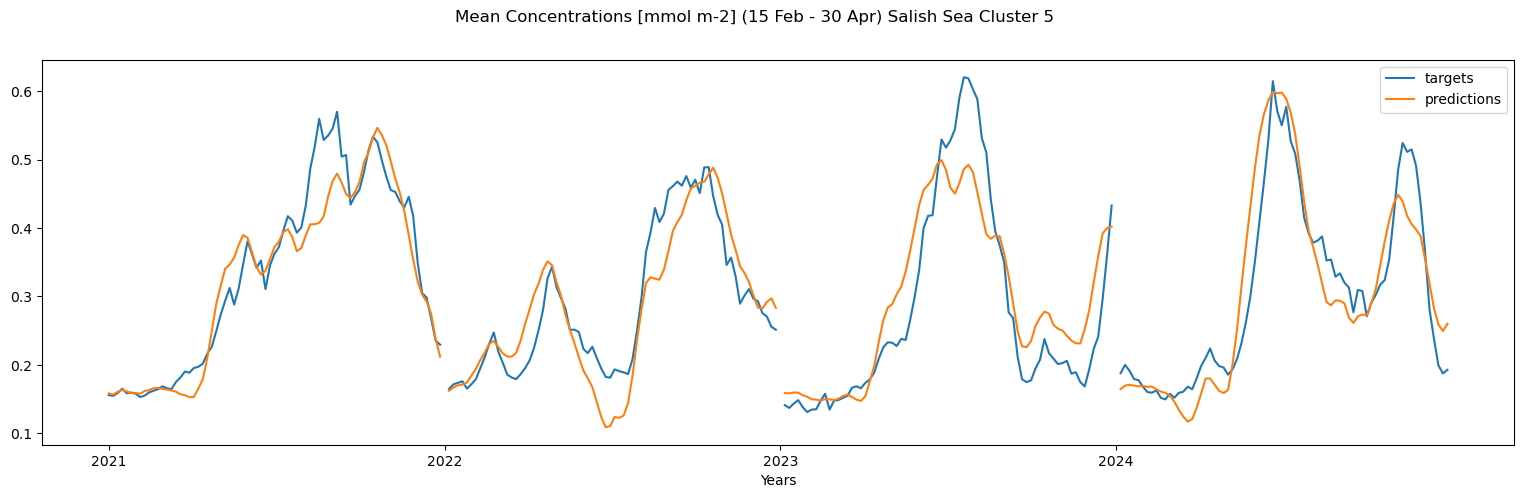

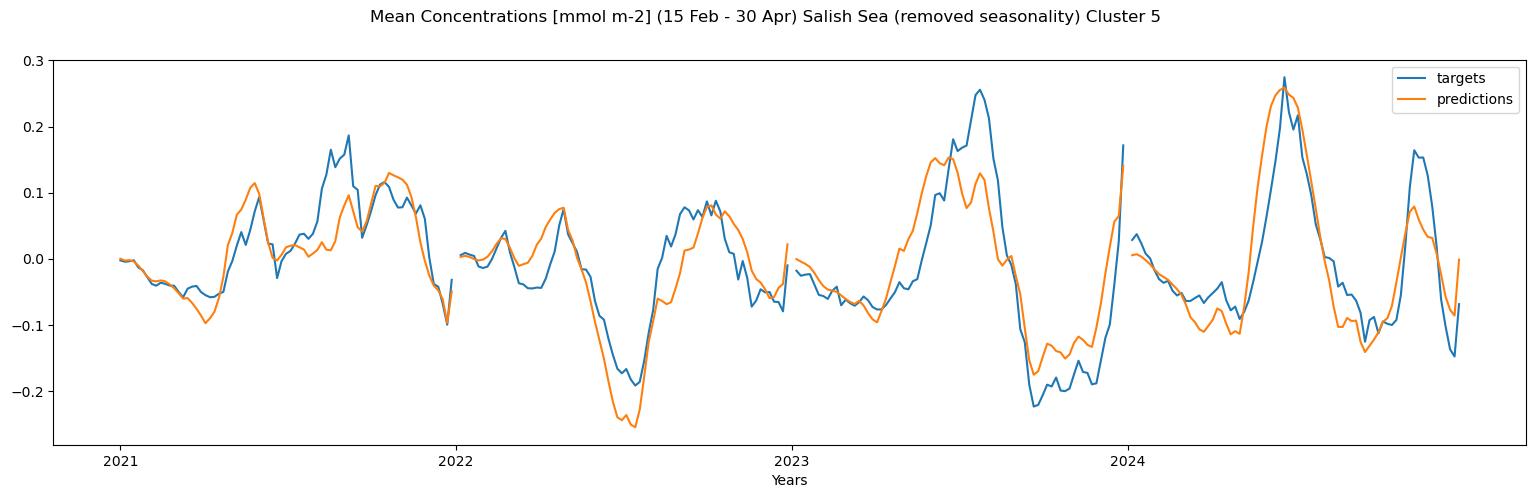

r_test  rms_test  slope_test
2021   0.967  0.024948       1.062
2022   0.866  0.030007       1.154
2023   0.923  0.026909       0.949
2024   0.950  0.024602       1.013

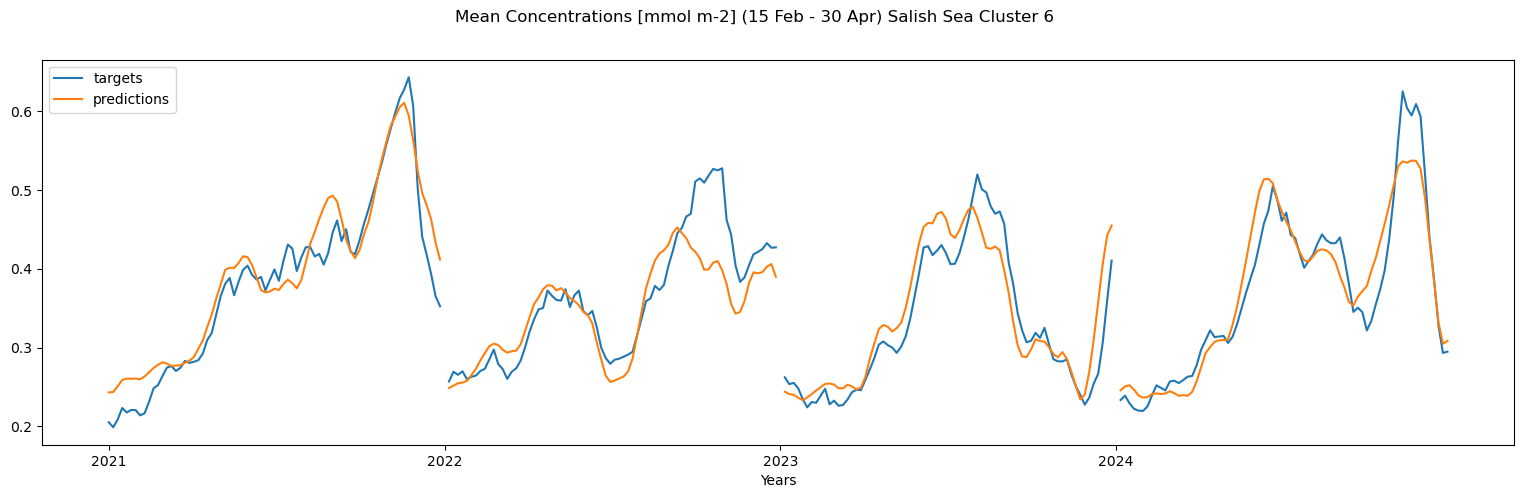

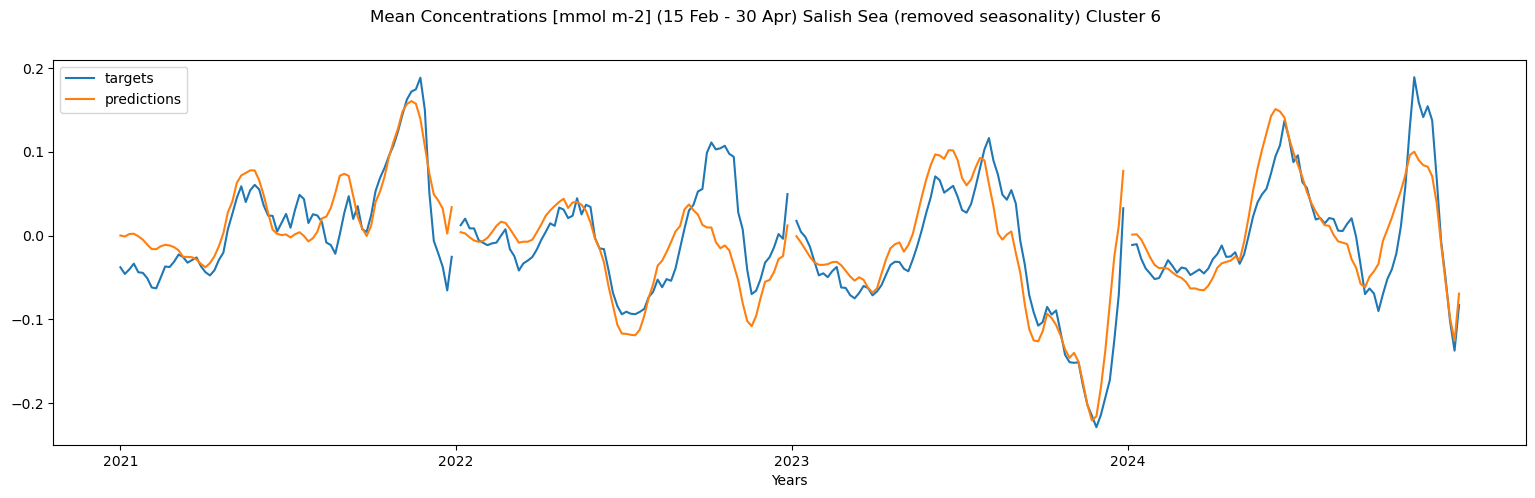

In [21]:
dataset = ds.sel(time_counter= slice('2021', '2024'))
dataset2 = ds2.sel(time_counter= slice('2021', '2024'))

years = np.unique(dataset.time_counter.dt.year)

targets_mean = np.zeros((len(np.unique(clusters)),len(dates)))
predictions_mean = np.zeros((len(np.unique(clusters)),len(dates)))

r_test = np.zeros((len(np.unique(clusters)),len(years)))
rms_test = np.zeros((len(np.unique(clusters)),len(years)))
slope_test = np.zeros((len(np.unique(clusters)),len(years)))

inputs, targets, indx, clusters  = datasets_preparation(dataset, dataset2, clusters0, name)

predictions = np.full(targets.shape,np.nan) # size of targets without nans
for i in range (0,len(np.unique(clusters))):
    indx2 = np.where(clusters==i) # indexes of the i cluster
    inputs2 = inputs[:,:,indx2[0]] # inputs of the i cluster
    targets2 = targets[:,indx2[0]] # targets of the i cluster
    predictions[:,indx2[0]] = scaling(regr_all[i],inputs2,scaler_inputs_all[i],targets,scaler_targets_all[i],smoother_all[i]) # putting them in the right place
    predictions2 = predictions[:,indx2[0]]

    targets_mean_temp = np.split(targets2,len(np.unique(dates.year)),axis=1)
    targets_mean_temp = np.ravel(targets_mean_temp)
    targets_mean_temp = np.reshape(targets_mean_temp,(len(dates),int(len(indx2[0])/len(np.unique(dates.year)))))
    targets_mean[i] = np.mean(targets_mean_temp,axis=1)

    predictions_mean_temp = np.split(predictions2,len(np.unique(dates.year)),axis=1)
    predictions_mean_temp = np.ravel(predictions_mean_temp)
    predictions_mean_temp = np.reshape(predictions_mean_temp,(len(dates),int(len(indx2[0])/len(np.unique(dates.year)))))
    predictions_mean[i] = np.mean(predictions_mean_temp,axis=1)

    for year in range (0, len(years)):
        r_test[i,year] = np.round(np.corrcoef(predictions_mean[i,np.where(dates.year==years[year])],targets_mean[i,np.where(dates.year==years[year])])[0][1],3)
        rms_test[i,year] = rmse(predictions_mean[i,np.where(dates.year==years[year])],targets_mean[i,np.where(dates.year==years[year])])
        m,_ = np.polyfit(np.squeeze(predictions_mean[i,np.where(dates.year==years[year])]),np.squeeze(targets_mean[i,np.where(dates.year==years[year])]), deg=1)
        slope_test[i,year] = np.round(m,3)

    temp = pd.DataFrame(np.vstack((r_test[i],rms_test[i],slope_test[i])).transpose(),index=[np.unique(dataset.time_counter.dt.year)],columns=['r_test','rms_test','slope_test'])
    display(temp)

    plotting_mean_values(dates, targets_mean[i], predictions_mean[i], units, category, 'Salish Sea Cluster '+str(i+1))
    plotting_mean_values(dates, targets_mean[i]-season[i,0:len(targets_mean[i])], predictions_mean[i]-season[i,0:len(targets_mean[i])], 
        units, category, 'Salish Sea (removed seasonality) Cluster '+str(i+1))
    

In [22]:
# dummy variables
slope_test = np.nan
slope_test_season = np.nan

r_season = np.nan
rms_season = np.nan

## Saving

In [34]:
if id == 0:
    path = '/data/ibougoudis/MOAD/files/results/' + name + '/func_reg_cl_target_full2/'
else:
    path = '/data/ibougoudis/MOAD/files/results/' + name + '/func_reg_cl_drivers/'

os.makedirs(path, exist_ok=True)
with lzma.open(path + 'regr_all.xz', 'wb') as f:
    
    dill.dump(regr_all, f)

with open(path + 'metrics.pkl', 'wb') as f:
    dill.dump([r_train,rms_train,slope_train,r_test[:,0],rms_test[:,0],slope_test,r_season,rms_season,slope_test_season,dates_season,season], f)

file_creation(path, targets_all, 'Targets')
file_creation(path, predictions_all, 'Predictions')
file_creation(path, (targets_all-predictions_all), 'Targets - Predictions')


TypeError: 'float' object is not subscriptable